# Research Paper: Web Scraping and Fundamental Analysis
by Alexander Schlaubitz and Gaudenz Dual  
January 2021

### Introduction

This Jupyter notebook shows how the user can scrape financial data from an American stock by simply entering its ticker in lowercase, e.g. for Coca Cola enter 'ko'. The notebook is split into three parts:

#### Part 1
In the first part, financial statements and other figures of a company are scraped from the web. These included income statements, balance sheets, cash flow statements, valuations measures, such as PE ratios and a historical dividend overview.

#### Part 2
In the second part, the scraped data is used to calculate the intrinsic stock value of the company, based on a dividend discount model, a discounted cash flow model, a multiples evaluation and an aggregation of other financial analyst's price targets. The different models are combined to create a graphical output that can be used to create buy, hold or sell recommendation for the company. This part represents the fundamental analysis.

#### Part 3
In a third step, natural language processing is applied to scraped news articles from Reuters.com. The news articles are analyzed based on sentiment (positive / negative) and that information is taken as a trend indication for the sentiment of the stock. 

The theoretical background to the different applications and models can be found in the written paper for this project. The code is further explained with comments and can be used as a reference when reading the paper. Running this notebook requires the user to have access to the following Python libraries:
- Pandas
- openpyxl
- BeautifulSoup
- Selenium - Detailed information on how to install the executable path for the Chrome browser can be found here: https://selenium-python.readthedocs.io/installation.html
- yfinance
- nltk

For easier display of code functionality, a screencaptured video of the working code is handed in together with the paper and this code. Additionally, given that Yahoo Finance and Investing.com, the two main references in the scraping process may spontaneously change their layouts or scraping policies, the scraped data for five sample companies, namely Coca Cola, Johnson& Johnson, Gilead Sciences, Intel and IBM, has been downloaded and stored in excel format, which can be imported in the code to show its functionality in retrospect.

In [1]:
#import required modules for web scraping and dataframe handling
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import math
import time
import openpyxl
from openpyxl import load_workbook

In [2]:
#ENTER TICKER OF AN AMERICAN STOCK IN LOWERCASE, e.g. 'ko', or 'jnj'
ticker = input("Enter Ticker: ").upper()

Enter Ticker: ko


Scraping data from the internet does rely on constant html codes, a change on a website might lead to a mailfunction in the code. In this case, the following two code snippets can be used to import data scraped by this model in advance. If so, the model will do a fundamental analysis on the basis of that data. However, in case of an error, we recommend to run the respective part couple more times to be sure that there was not an error with the internet connection. Also we recommend not to interfere with inputs from the mouse or keyboard while the code is running.

In [3]:
#To import excel data change to True and enter file name, else ignore and skip
import_button = False
if import_button == True:
    company_xlsx = input("Use pre downloaded data: Input possibilities: ko.xlsx, gild.xlsx, ibm.xlsx, intc.xlsx, jnj.xlsx ")


In [4]:
#To export data change to True, else ignore and skip
file_name = ticker.lower() + ".xlsx"
export_button = False

# Part 1: Income Statement
Numbers in thousands

The following code shows how the income statements of an american company can be downloaded from Yahoo Finance using BeautifulSoup. Income statements on Yahoo Finance usually have data from 31.12.2016 to 31.12.2019, including a TTM overview. However, not all stocks have this income statement layout, for example Apple with ticker 'AAPL' does not have any data for 2016 on Yahoo Finance. Hence, the code was programmed in a flexible way to account for these inconsistencies.

In [5]:
#defining URL for beautifulsoup
url = 'https://finance.yahoo.com/quote/'+ticker+'/financials?p='+ticker
print(url)

https://finance.yahoo.com/quote/KO/financials?p=KO


In [6]:
#define beautiful soup parser, which url to download and to search for first column of financials
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

income_statement = soup.find(id = "Col1-1-Financials-Proxy") #find the html code on the website with this id
#print(income_statement.prettify()) to show html result

#everything as string so that '-', which are empty slots, are included
work = []
for string in income_statement.strings:
    work.append((string))
#    print(repr(string))

work = pd.DataFrame(work, columns=['info'] ) #list to pandas
print(len(work+'rows')) # 220 rows is the normal layout, AAPL has 171, AXP 160, BA 208 - so its wildly mixed and not consitent, this has to be accounted for
df = work #renaming it for function below

# Inspiration for the function from: https://www.geeksforgeeks.org/find-location-of-an-element-in-pandas-dataframe-in-python/
# This function will return a list of positions where element exists in the dataframe. dfObj is my dataframe and
# value is the number or text that i am looking for in the dataframe. Lets say i look for the value 'Total Revenue'
def getIndexes(dfObj, value): 

    listOfPos = [] # Empty list 
      
    # isin() method will return a dataframe with boolean values, True at the positions where element exists 
    result = dfObj.isin([value]) #df.isin(['Total Revenue'])
      
    # any() method will return a boolean series 
    seriesObj = result.any() #if there is a True anywhere in the dataframe this returns True
  
    # Get list of column names where element exists 
    columnNames = list(seriesObj[seriesObj == True].index) #index gives me the column name where there is a True
     
    # Iterate over the list of columns and extract the row index where element exists 
    for col in columnNames: 
        rows = list(result[col][result[col] == True].index) 
  
        for row in rows: 
            listOfPos.append((row, col)) 
              
    # This list contains a list tuples with the index of element in the dataframe 
    return listOfPos 
  
# Calling getIndexes() function to get the index positions of all occurrences of 'Total Revenue' in the dataframe 
listOfPositions = getIndexes(df, 'Total Revenue') 

#getting the position of Total Revenue in the dataframe
pos = listOfPositions[0][:1]
pos = pos[0] #the row number that contains 'Total Revenue', everything in the dataframe above that is not needed.

work2 = work.drop(work.index[0:pos]).reset_index(drop=True)#drop the first 20 rows of useless data

#Create the dataframe for the whole balance sheet

# has2016 =work[work['info'].str.contains('12/31/2016')] #other possibility for the below
has2016 =work[work['info'].str.contains('2016')] #if the dataframe contains 2016 it returns True
if(has2016.any()[0]==True): #if first object in has2016.any() is True, then
    work3 = work2[work2.index % 6 == 0].reset_index(drop=True) #return every sixth value and start a zero
    # and reset the index back to 0,1,2,3 etc.
    work3.rename(columns={work.columns[0]:"Title"}, inplace=True)#rename the first and only column 

    work3['TTM'] = work2[work2.index % 6 == 1].reset_index(drop=True) #every sixth value from index 1
    work3['12/30/2019'] = work2[work2.index % 6 == 2].reset_index(drop=True) #every sixth value from index 2 and so on...
    work3['12/30/2018'] = work2[work2.index % 6 == 3].reset_index(drop=True)
    work3['12/30/2017'] = work2[work2.index % 6 == 4].reset_index(drop=True)
    work3['12/30/2016'] = work2[work2.index % 6 == 5].reset_index(drop=True)

    work3.drop(work3.tail(1).index, inplace=True) #dropping last row because its "Get Yahoo Premium now"
    income_statement = work3
    display(income_statement)
else:
   #in case len(work) is < 220
    work4 = work2[work2.index % 5 == 0].reset_index(drop=True) #return every sixth value and start a zero
    #reset the index back to 0,1,2,3 etc.
    work4.rename(columns={work.columns[0]:"Title"}, inplace=True)#rename the first and only column 

    work4['TTM'] = work2[work2.index % 5 == 1].reset_index(drop=True)
    work4['12/30/2019'] = work2[work2.index % 5 == 2].reset_index(drop=True)
    work4['12/30/2018'] = work2[work2.index % 5 == 3].reset_index(drop=True)
    work4['12/30/2017'] = work2[work2.index % 5 == 4].reset_index(drop=True)

    work4.drop(work4.tail(1).index, inplace=True) #dropping last row because its "Get Yahoo Premium now" 
    income_statement = work4
    display(income_statement)

214


,Title,TTM,12/30/2019,12/30/2018,12/30/2017,12/30/2016
0,Total Revenue,"33,471,000","37,266,000","31,856,000","35,410,000","41,863,000"
1,Cost of Revenue,"13,421,000","14,619,000","11,770,000","13,256,000","16,465,000"
2,Gross Profit,"20,050,000","22,647,000","20,086,000","22,154,000","25,398,000"
3,Operating Expense,"10,377,000","12,114,000","10,305,000","12,727,000","15,262,000"
4,Operating Income,"9,673,000","10,533,000","9,781,000","9,427,000","10,136,000"
5,Net Non Operating Interest Income Expense,"-933,000","-383,000","-237,000","-164,000","-91,000"
6,Other Income Expense,"1,068,000","636,000","-1,194,000","-2,521,000","-1,909,000"
7,Pretax Income,"9,808,000","10,786,000","8,350,000","6,742,000","8,136,000"
8,Tax Provision,"1,449,000","1,801,000","1,623,000","5,560,000","1,586,000"
9,Net Income Common Stockholders,"8,333,000","8,920,000","6,434,000","1,248,000","6,527,000"


# Part 1: Balance Sheet
Numbers in thousands

The following code shows how the balance sheets of an American company can be downloaded  from Yahoo Finance using Selenium.  

Similarly to the income statements, not all historical data is available on the website for every stock. Furthermore, all positions of the balance sheet must be downloaded for the purposes of fundamental analysis. However, Yahoo Finance only shows a summarized table which first has to be expanded (e.g. current assets and total non-current assets are summarized under Total Asssets). Expanding the balance sheet can be done by clicking a button on the website and therefore Selenium webdriver is used to automate this process.

In [7]:
#redefining URL to access the balance sheet website of the company
URL = 'https://finance.yahoo.com/quote/'+ticker+'/balance-sheet?p='+ticker 
print(URL)

https://finance.yahoo.com/quote/KO/balance-sheet?p=KO


In [8]:
#how to install selenium and configure web driver:
#https://selenium-python.readthedocs.io/installation.html
#https://medium.com/@vikasthamke/web-scraping-historical-stock-market-data-from-yahoo-finance-using-selenium-and-beautifulsoup-in-691c625a79f1

from selenium import webdriver
import time

#Selenium is uniquely installed on a user's computer path, hence the executable path has a different location for Alex and Gaudenz
#If you would like to run this code yourself you have to enter the path of the chromedriver application yourself, as
#we do down below:

#Alex
driver = webdriver.Chrome(executable_path = r"C:\Webdriver\chromedriver.exe")# Hit the url of Yahoo Finance and wait for 2 seconds.
#Gaudenz
#driver = webdriver.Chrome('/Applications/Webdriver/chromedriver')
driver.get(URL)
time.sleep(2) #wait for 2 seconds to allow the website to load

In [9]:
#click the expand all button
data_set = driver.find_elements_by_xpath("//span[text() = 'Expand All']")[0].click() #expand the data table
#extract data table now that everything is expanded
data_set = driver.find_element_by_xpath("//div[@class='M(0) Whs(n) BdEnd Bdc($seperatorColor) D(itb)']")

a = data_set.text.split(sep='\n') #split the data based on 'spaces'

In [10]:
#create data table with the downloaded data
balance = pd.DataFrame(a, columns={'Title':a})
if('12/30/201912/30/201812/30/201712/30/2016' in balance['Title'].values): #do we have data since 2016? Sometimes this is not the case
    title = balance.iloc[2:].iloc[::2].reset_index(drop=True) #kick out the first 2 rows, then give out every second row and reset the index
    numbers = balance['Title'].str.split(" ", n=3, expand=True)#split the text in Title with separator " " (space)
    numbers.rename({0:'12/30/2019', 1:'12/30/2018', 2:'12/30/2017', 3:'12/30/2016'}, axis='columns', inplace=True) #give the 3 new rows a name
    numbers = numbers.iloc[3:].iloc[::2].reset_index(drop=True) #drop the first three rows, only show every second row
    balance_sheet = pd.concat([title, numbers], axis=1) #combine the title df and the number df
    display(balance_sheet)
else: #this is the same code as above, but str.split() has n=2 instead of n=3, which accounts for the fact that potentially no data from 2016 is available
    title = balance.iloc[2:].iloc[::2].reset_index(drop=True) #kick out the first 2 rows, then give out every second row and reset the index
    numbers = balance['Title'].str.split(" ", n=2, expand=True)#split the text in Title with separator " " (space)
    numbers.rename({0:'12/30/2019', 1:'12/30/2018', 2:'12/30/2017', 3:'12/30/2016'}, axis='columns', inplace=True) #give the 3 new rows a name
    numbers = numbers.iloc[3:].iloc[::2].reset_index(drop=True) #drop the first three rows, only show every second row
    balance_sheet = pd.concat([title, numbers], axis=1) #combine the title df and the number df
    display(balance_sheet)


,Title,12/30/2019,12/30/2018,12/30/2017,12/30/2016
0,Total Assets,"86,381,000","83,216,000","87,896,000","87,270,000"
1,Current Assets,"20,411,000","30,634,000","36,545,000","34,010,000"
2,"Cash, Cash Equivalents & Short Term Investments","11,175,000","15,964,000","20,675,000","22,201,000"
3,Cash And Cash Equivalents,"6,480,000","8,926,000","6,006,000","8,555,000"
4,Other Short Term Investments,"4,695,000","7,038,000","14,669,000","13,646,000"
...,...,...,...,...,...
67,Total Debt,"42,763,000","43,555,000","47,685,000","45,709,000"
68,Net Debt,"36,283,000","34,629,000","41,679,000","37,154,000"
69,Share Issued,"7,040,129","7,040,129","7,040,000","7,040,000"
70,Ordinary Shares Number,"4,280,129","4,268,129","4,259,000","4,288,000"


# Part 1: Cash Flow
Numbers in thousands

The following code shows how to download the cash flow statements of an American company on Yahoo Finance.

As in the other two financial statements, not all companies have data for 2016, even though they have existed at that point in time. Once again, the cash flow table on the website has to be expanded first, before downloading it, hence Selenium is used again.

In [11]:
driver.get(URL)#reload driver, otherwise there is an error
time.sleep(1)
driver.find_elements_by_xpath("//span[text() = 'Cash Flow']")[0].click() # driver finds more than 1 CASH flow text
time.sleep(2)

In [12]:
driver.find_elements_by_xpath("//span[text() = 'Expand All']")[0].click() #again, expand all table positions

#find the table where all text is located
data12 = driver.find_element_by_xpath("//div[@class='M(0) Whs(n) BdEnd Bdc($seperatorColor) D(itb)']")

split = data12.text.split(sep='\n') #split the data based on 'spaces'
cashflow = pd.DataFrame(split, columns={'Title':split})

#Create the Cash Flow table
if('TTM12/30/201912/30/201812/30/201712/30/2016' in cashflow['Title'].values): #do we have data since 2016?
    title_cf = cashflow.iloc[2:].iloc[::2].reset_index(drop=True) #kick out the first 2 rows, then give out every second row and reset the index
    numbers_cf = cashflow['Title'].str.split(" ", n=4, expand=True)#split the text in Title with separator " " (space)
    numbers_cf.rename({0:'TTM', 1:'12/30/2019', 2:'12/30/2018', 3:'12/30/2017', 4:'12/30/2016'}, axis='columns', inplace=True) #give the 3 new rows a name
    numbers_cf = numbers_cf.iloc[3:].iloc[::2].reset_index(drop=True) #drop the first three rows, only show every second row
    cash_flow = pd.concat([title_cf, numbers_cf], axis=1) #combine the title df and the number df
    display(cash_flow)
else: #this is the same code as above, but str.split() has n=2 instead of n=3
    title_cf = cashflow.iloc[2:].iloc[::2].reset_index(drop=True) #kick out the first 2 rows, then give out every second row and reset the index
    numbers_cf = cashflow['Title'].str.split(" ", n=3, expand=True)#split the text in Title with separator " " (space)
    numbers_cf.rename({0:'TTM', 1:'12/30/2019', 2:'12/30/2018', 3:'12/30/2017', 4:'12/30/2016'}, axis='columns', inplace=True) #give the 3 new rows a name
    numbers_cf = numbers_cf.iloc[3:].iloc[::2].reset_index(drop=True) #drop the first three rows, only show every second row
    cash_flow = pd.concat([title_cf, numbers_cf], axis=1) #combine the title df and the number df
    display(cash_flow)

,Title,TTM,12/30/2019,12/30/2018,12/30/2017,12/30/2016
0,Operating Cash Flow,"8,920,000","10,471,000","7,627,000","7,106,000","8,796,000"
1,Cash Flow from Continuing Operating Activities,"8,920,000","10,471,000","7,320,000","6,995,000","8,796,000"
2,Net Income from Continuing Operations,"8,359,000","8,985,000","6,727,000","1,182,000","6,550,000"
3,Operating Gains Losses,"-1,760,000","-797,000","-306,000","1,112,000","855,000"
4,Net Foreign Currency Exchange Gain Loss,"-133,000","91,000","-38,000","281,000","158,000"
5,Earnings Losses from Equity Investments,"-650,000","-421,000","-457,000","-628,000","-449,000"
6,Depreciation Amortization Depletion,"1,506,000","1,365,000","1,086,000","1,260,000","1,787,000"
7,Depreciation & amortization,"1,506,000","1,365,000","1,086,000","1,260,000","1,787,000"
8,Deferred Tax,"56,000","-280,000","-450,000","-1,256,000","-856,000"
9,Deferred Income Tax,"56,000","-280,000","-450,000","-1,256,000","-856,000"


# Part 1: Valuation measures
Numbers are mixed from trillion to billion to ratios

The following code shows how to download the valuation measures table from Yahoo Finance.

The layout of this table is different than for the three previous financial statements, as it is split into quarterly instead of yearly data points. For the purpose of financial analysis only the most recent data, shown in the column 'current' is of interest.

In [13]:
statistics_url = 'https://finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker #define URL
driver.get(statistics_url )#reload driver, otherwise there is an error

time.sleep(1) #wait one second before loading
val = driver.find_element_by_xpath("//div[@class='M(0) Whs(n) BdEnd Bdc($seperatorColor) D(itb)']") #find the table containing the data

val = val.text.split(sep='\n') #split the data based on 'spaces'


In [14]:
#Create the valuation measures dataframe and turn the numbers from text into actual numeric numbers (integers)
valuation = pd.DataFrame(val, columns={'Title':val})
title_val = valuation.iloc[1:].iloc[::2].reset_index(drop=True) #cut out the title and reset index
numbers_val = valuation['Title'].str.split(" ", n=5, expand=True) 
numbers_val = numbers_val.iloc[2:].iloc[::2].reset_index(drop=True)
numbers_val.rename({0:'Current', 1:'9/30/2020', 2:'6/30/2020', 3:'3/31/2020', 4:'12/31/2019', 5:'9/30/2019'}, axis='columns', inplace=True) #give the new rows a name
valuation_measures = pd.concat([title_val, numbers_val], axis=1) #combine the title df and the number df

val_title = valuation_measures.iloc[:2,:1]#cut out title first two rows and save it
val_clean = valuation_measures.iloc[:2,1:-1]#cut away title and last column
val_B = val_clean.applymap(lambda x: str(x.replace('B', '000000000'))) #change B to 9 zeros
val_T = val_B.applymap(lambda x: str(x.replace('T','000000000000'))) # change T to 12 zeros
val_cleaned = val_T.applymap(lambda x: str(x. replace('.', ''))) #replace dots with nothing

together = val_title.join(val_cleaned) #join first two titles with the numbers
valuation = together.append(valuation_measures.iloc[2:,:-1]) #join the first two complete rows with the rest of the data
val_title = valuation_measures.iloc[:,:1] #only the titles, because those should not be numeric

valuation_numeric = valuation.iloc[:,1:].apply(pd.to_numeric, errors='coerce') #turn everything into numeric (int64), coerce makes '-' into NaN
valuation_measures = val_title.join(valuation_numeric) #join the original titles with the numeric made numbers

valuation_measures

,Title,Current,9/30/2020,6/30/2020,3/31/2020,12/31/2019
0,Market Cap (intraday) 5,2.296500e+13,2.121400e+13,1.919000e+13,1.900100e+13,2.369000e+13
1,Enterprise Value 3,2.613900e+13,2.446600e+13,2.246300e+13,2.216000e+13,2.677100e+13
2,Trailing P/E,2.769000e+01,2.329000e+01,1.926000e+01,2.138000e+01,2.944000e+01
3,Forward P/E 1,2.451000e+01,2.262000e+01,2.320000e+01,2.024000e+01,2.457000e+01
4,PEG Ratio (5 yr expected) 1,4.630000e+00,4.130000e+00,3.860000e+00,3.000000e+00,4.150000e+00
5,Price/Sales (ttm),6.900000e+00,6.220000e+00,5.190000e+00,5.120000e+00,7.110000e+00
6,Price/Book (mrq),1.234000e+01,1.213000e+01,1.057000e+01,1.001000e+01,1.266000e+01
7,Enterprise Value/Revenue 3,7.810000e+00,2.828000e+01,3.142000e+01,2.576000e+01,2.952000e+01
8,Enterprise Value/EBITDA 6,2.062000e+01,7.648000e+01,7.876000e+01,6.207000e+01,8.763000e+01


We noted that the numbers here included 'T' for Trillion and 'B' for Billion and therefore are strings. Numpy cannot calculate with strings and therefore B and T were turned into the correct amount of zeros and attached to the number. The same applies for numbers such as '122.08', these are all stored as strings and not as numbers thus calculating 122.08 + 122.08 would give us 122.08122.08 instead of 244.16. The same applies to the data stored in balance_sheet, cash_flow and income_statement. As this is applied to all three we define the process ofchanging strings to integers in a function.

In [15]:
def my_func(df): #works for cash_flow, balance_sheet and income_statement
    title = df[df.columns[:1]] #select only the first column, this should be kept as string
    cut = df[df.columns[1:]] #select everything except the first column
    cut2 = cut.applymap(lambda x: str(x.replace(',',''))) #replace commas with nothing
    cut3 = cut2.apply(pd.to_numeric, errors='coerce', downcast = 'float') #turn everything into numeric (int64), coerce makes '-' into NaN
    final = title.join(cut3*1000) #combine title and the now numbers again and multiply with 1000 because all numbers in thousands

    return final

#apply the function of all three statements to turn the data into numbers
income_statement = my_func(income_statement)
balance_sheet = my_func(balance_sheet)
cash_flow = my_func(cash_flow)

In [16]:
#export data function, special case for first export because we need to create the excel first via this code
if export_button == True:
    with pd.ExcelWriter(file_name) as writer:
        income_statement.to_excel(writer, sheet_name = "income_statement")

In [17]:
#export data, only runs if export_button was set to True at the start of the notebook
if export_button == True:
    book = load_workbook(file_name)
    writer = pd.ExcelWriter(file_name, engine = 'openpyxl')
    writer.book = book
    balance_sheet.to_excel(writer, sheet_name = "balance_sheet")
    cash_flow.to_excel(writer, sheet_name = "cash_flow")
    valuation_measures.to_excel(writer, sheet_name = "valuation_measures")
    writer.save()
    writer.close()

In [18]:
#import data, only runs if import_button was set to True at the start of the notebook
if import_button == True:
    income_statement = pd.read_excel(company_xlsx, sheet_name = "income_statement")
    balance_sheet = pd.read_excel(company_xlsx, sheet_name = "balance_sheet")
    cash_flow = pd.read_excel(company_xlsx, sheet_name = "cash_flow")
    valuation_measures = pd.read_excel(company_xlsx, sheet_name = "valuation_measures")
    
    balance_sheet = balance_sheet.drop(columns = ['Unnamed: 0'])
    cash_flow = cash_flow.drop(columns = ['Unnamed: 0'])
    income_statement = income_statement.drop(columns = ['Unnamed: 0'])
    valuation_measures = valuation_measures.drop(columns = ['Unnamed: 0'])

# Part 1: Overview of Historical Dividends

The following code shows how to download a historical dividend overview for an American company from investing.com.


Yahoo Finance offers an overview of historical dividends as well, however to further test the applicability of web scraping we gather the dividends data from another website: investing.com. Generally, it is important to mention that due to the qualitiy and amount of free data offered by yahoo finance, there are Python APIs in existence for pulling data from Yahoo Finance without having to scrape the website ourselves (see yfinance example below). However, as other website might offer specific data not covered by yahoo it makes sense to get familiar with scraping multiple different websites.

For that matter we also quickly show how useful these Python APIs can be as an alternative to manually defining a web scraping process.

In [19]:
import yfinance as yf
import matplotlib as plt
stock = yf.Ticker(ticker)
hist = stock.history(period="max")
current_price = (hist.tail(1)['Close'].iloc[0])

The current price of the stock is:  54.15999984741211


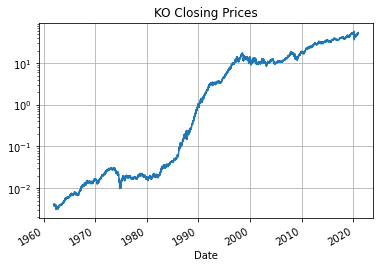

In [20]:
hist.Close.plot(title = ticker + " Closing Prices", #get all closing prices
               grid = True)
plt.pyplot.yscale("log") #plot them on a log scale

print('The current price of the stock is: ', current_price)

We see that getting data via the yfinance API is very simple compared to the scraping process.

When using investing.com, the first thing we notice is that its URL search is not as intuitive as with Yahoo Finance, where we can directly access a stocks website using its ticker in the url. Investing.com is using the complete name of a company in the URL, for example Bank of America with the ticker BA has the following URL: https://www.investing.com/equities/bank-of-america-dividends

We could now either create a dict where we assign each ticker its real name (for example {'BAC' : 'bank-of-america'} and then directly scrape the data from the website using Beautifulsoup as we did for the income statement. However, by creating a dict we would have to limit ourselves to a certain amount of stocks, as we have to create the dict by hand and thus indicate which stocks can be reviewed and which not. We prefer to have a little more flexibility work our way around this by using Selenium to guide ourselves automatically through the website.

In [22]:
#need to import the errors so that they can be referenced
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException, ElementClickInterceptedException

#define the url
invest_url = 'https://www.investing.com/'
driver.get(invest_url )#reload driver, otherwise there is an error

#find the search bar, enter the ticker and the click on financials and then the dividend tab
driver.find_element_by_xpath("//input[@class='searchText arial_12 lightgrayFont js-main-search-bar']").send_keys(ticker)
time.sleep(1) #wait for a second
driver.find_element_by_xpath("//label[@class='searchGlassIcon js-magnifying-glass-icon']").click() #click the search bar

time.sleep(1)
driver.find_element_by_xpath("//span[@class='flag first']").click()#click the first element (more specifically the flag)

time.sleep(2)
driver.find_element_by_xpath("//a[text() ='Financials']").click() #click financials tab

time.sleep(1)
driver.find_element_by_xpath("//a[text() ='Dividends']").click() #click dividend tab


#check if dividends exist for the stock or not
time.sleep(1)
while True:
    go = 'yes'
    try:#do that until show more button does not exist anymore
        driver.find_element_by_xpath("//a[text() ='Show more']").click() #this expands the historical dividend overview
    except NoSuchElementException: #no dividends for the stock
        go ='no'
     
        break
    except (ElementNotInteractableException, ElementClickInterceptedException): #in case of errors stop, erros would mean that the show more button no longer exists, meaning that all available data is displayed.
    
        break
        
if go == 'yes': #dividends exist, continue
    warning = 'None'
    div = driver.find_element_by_xpath("//table[@class = 'genTbl closedTbl dividendTbl' ]") #find table elements
    div = div.text.split(sep='\n')
    dividends = pd.DataFrame(div, columns={'Title':div}) #put dividends in a dataframe
    
    display(dividends)
    
    #clean the dataframe and aggregate dividends from quarterly to yearly
    numbers_val = dividends['Title'].str.split(" ", n=7, expand=True)
    numbers_val.rename({0:'date', 1:'date2', 2:'full_year', 3:'dividend', 4:'noneed1', 5:'noneed2', 6:'noneed3',7:'div_yield'}, axis='columns', inplace=True) #give the new rows a name
    numbers_val['date'] = numbers_val['date']+" "+numbers_val['date2']+" "+numbers_val['full_year']
    numbers_val['dividend'] = pd.to_numeric(numbers_val['dividend'],errors='coerce') #make dividends numeric


    yearly_dividends = numbers_val.groupby('full_year')[['dividend']].sum().iloc[:-1] #groupby year and dividend sum
    all_dividends = numbers_val[['date', 'dividend', 'div_yield']].iloc[1:,:]
    
    display(all_dividends)
    display(yearly_dividends)
    
else: #in case dividends do not exist for the stock, print the following.
    warning = 'The stock does not pay out dividends'
    print('The stock does not pay out dividends')
    
driver.close() #close google chrome

,Title
0,Ex-Dividend Date Dividend Type Payment Date Yield
1,"Nov 30, 2020 0.41 Dec 15, 2020 3.07%"
2,"Sep 14, 2020 0.41 Oct 01, 2020 3.27%"
3,"Jun 12, 2020 0.41 Jul 01, 2020 3.53%"
4,"Mar 13, 2020 0.41 Apr 01, 2020 3.61%"
5,"Nov 29, 2019 0.4 Dec 16, 2019 2.68%"
6,"Sep 13, 2019 0.4 Oct 01, 2019 2.99%"
7,"Jun 13, 2019 0.4 Jul 01, 2019 3.07%"
8,"Mar 14, 2019 0.4 Apr 01, 2019 3.32%"
9,"Nov 29, 2018 0.39 Dec 14, 2018 3.48%"


,date,dividend,div_yield
1,"Nov 30, 2020",0.410,3.07%
2,"Sep 14, 2020",0.410,3.27%
3,"Jun 12, 2020",0.410,3.53%
4,"Mar 13, 2020",0.410,3.61%
5,"Nov 29, 2019",0.400,2.68%
6,"Sep 13, 2019",0.400,2.99%
7,"Jun 13, 2019",0.400,3.07%
8,"Mar 14, 2019",0.400,3.32%
9,"Nov 29, 2018",0.390,3.48%
10,"Sep 13, 2018",0.390,3.43%


,dividend
full_year,
2013,0.56
2014,1.22
2015,1.32
2016,1.40
2017,1.48
2018,1.56
2019,1.60
2020,1.64


In [23]:
#export data function
if export_button == True:
    book = load_workbook(file_name)
    writer = pd.ExcelWriter(file_name, engine = 'openpyxl')
    writer.book = book
    yearly_dividends.to_excel(writer, sheet_name = "yearly_dividends")
    writer.save()
    writer.close()

In [24]:
#import data function
if import_button == True:
    yearly_dividends = pd.read_excel(company_xlsx, sheet_name = "yearly_dividends")

Up to this point, multiple financial figures and statements were scraped from either Yahoo Finance or Investing.com. Now this data can be put to use by calculating the theoretical intrinsic value of the selected ticker, using different models from the world of fundamental analysis.

# Part 2: Dividend Discount Model

The two stage dividend discount model is further explained in the paper.

<table><tr><td><img src='ddm.png' style="width: 750px;"></td></tr><table>
 
The code below shows calculations for the many different inputs for the DDM, as described in the paper for this project. Most data is available in the scraped financial statements, however, certain datapoints, such as risk-free rates are scraped from other websites using BeautifulSoup.

In [25]:
#Create everything as a big for-loop, as some stock do not pay out dividends. If not for the for-loop, the code would then stop
#here, even though a dcf and multiples evaluation would still be possible.

#First step is to find out if the company actually pays out dividends
if warning == 'The stock doesnt pay out dividends':
    print('The stock does not pay any dividends and therefore a DDM model valuation is not possible.')
else: #if the stock pays out dividends, calculate growth rates and display them
    print('Yearly Dividend Overview: ')
    display(yearly_dividends)
    print('Historical dividend growth rates: ')
    pct_change = yearly_dividends.pct_change(periods=1, fill_method='pad') #percent change to last year
    display(pct_change)
    
    import math
    def geomean(xs): #geometric mean as average growth rate for dividends
        return math.exp(math.fsum(math.log(x) for x in xs) / len(xs))

    outlier = pct_change.max() > 3*pct_change.mean() #if the largest value is three times larger than the average we 
    #treat it as an outlier
    if outlier.any() == True: #this tests if there is indeed an outlier (outlier.any() either True or False)
        print('Outlier was cut') 
        x = pct_change[pct_change.dividend.between(pct_change.dividend.quantile(0.), pct_change.dividend.quantile(.80))]
        # cutting out the upper 20%, so we only take values from 0 - 80 percentile.
        g_short = x.iloc[-5:].sum() / len(x) #sum of the growth rates, divided by their count to get the average growth rate
    else:
        last_five_div = pct_change.dividend.iloc[-5:].array #last five dividends
        g_short = geomean(last_five_div)
    
    net_income =  income_statement.iloc[9:10,2:3].to_numpy()[0][0] #find net income
    
    #stockholder equity
    position_stockholder_equity = getIndexes(balance_sheet, 'Stockholders\' Equity' ) 
    row = position_stockholder_equity[0][0]
    avg_stockholder_equity = balance_sheet.iloc[row:row+1, 1:2].to_numpy()[0][0]
    avg_stockholder_equity #this could also be average stockholder equity, so (stockholder equity 2019 + 2018 )/ 2
    
    ROE = net_income / avg_stockholder_equity #ROE is in percent
    
    eps =  income_statement.iloc[11:12,2:3].to_numpy()[0][0] #eps end 2019
    
    div_paid = yearly_dividends.iloc[-2:].to_numpy()[0][0] #dividends paid in 2019
    
    payout_ratio = div_paid / eps #payout ratio 2019
    
    # Sustainable growth rate = ROE x (1 - Dividend Payout Ratio) 
    g_long = ROE * (1-payout_ratio)
    
    #deciding on long-term growth rate, if it is above 4.25 % (the highest theoretically sensible growth rate of the american economy)
    #we trim it down to 2 %, which is the average growth rate of the american economy, and more applicable for DDM analysis.
    if g_long > 0.0425:
        print('g_long was at ', g_long, 'which is much larger than the growth of the american economy and therefore not sustainable in the longterm. We therefore choose the'
              ' average growth of 2% for the american market. ')
        g_long = 0.02

    
    # get risk-free rate by scraping the 10y gov bond rate from treasury.gov
    url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    rf = soup.find_all('td', attrs={ 'class' : 'text_view_data'})
    rf = float(rf[-3].get_text())/100 #picking the last row, and the middle value in there which is for the 13 week 
    #(=90day) yield of the t-bill

    # get beta by scraping it from Yahoo Finance
    url = 'https://finance.yahoo.com/quote/'+ticker+'?p='+ticker
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    beta = soup.find('td', attrs={ 'class' : 'Ta(end) Fw(600) Lh(14px)', 'data-test' : 'BETA_5Y-value'})
    beta = float(beta.get_text()) 

    #Calculate CAPM risk premium, return of the market is given as 8%.
    risk_premium = 0.08 - rf

    #Calculate CAPM, which represents the discount rate
    CAPM = rf + beta * (risk_premium)
    #Calculate the stages of the DDM model
    y1 = yearly_dividends.dividend.iloc[-1:].array* (1+g_short)
    y2 = y1 * (1+g_short)
    y3 = y2 * (1+g_short)
    y4 = y3 * (1+g_short)
    y5 = y4 * (1+g_short)

    y1_pv = y1 / (1+CAPM)**1
    y2_pv = y2 / (1+CAPM)**2
    y3_pv = y3 / (1+CAPM)**3
    y4_pv = y4 / (1+CAPM)**4
    y5_pv = y5 / (1+CAPM)**5

    stage1 = y1+y2+y3+y4+y5

    terminal_value = (y5*(1+g_short)) / (CAPM - g_long) 
    terminal_value_pv = terminal_value / ((1+CAPM)**6)
    DDM_value =  stage1 + terminal_value_pv
    #create final overview dataframe and then print everything
    DDM = pd.DataFrame(index = ['t+1','t+2','t+3','t+4','t+5'],data= {'Dividend': [y1[0],y2[0],y3[0],y4[0],y5[0]], 'Present_Value': [y1_pv[0], y2_pv[0], y3_pv[0],
                                                                                       y4_pv[0], y5_pv[0]]})
    DDM
    print('Risk Free rate in percent: ', rf*100)
    print('Beta of the stock against S&P 500: ', beta)
    print('Cost of Equity: ', CAPM)
    print('Short-term dividend growth rate: ', g_short)
    print('Long-term dividend growth rate: ', g_long)
    display(DDM)

    print('Intrinsic Value of',ticker, 'based on Dividend Discount Model is: ', DDM_value[0])
    print('Disclaimer: This model is very sensitive to changes to its input such as Beta, the cost resulting Cost of Equity and the\
          short and long term growth rates')

Yearly Dividend Overview: 


,dividend
full_year,
2013,0.56
2014,1.22
2015,1.32
2016,1.40
2017,1.48
2018,1.56
2019,1.60
2020,1.64


Historical dividend growth rates: 


,dividend
full_year,
2013,NaN
2014,1.178571
2015,0.081967
2016,0.060606
2017,0.057143
2018,0.054054
2019,0.025641
2020,0.025000


Outlier was cut
g_long was at  0.11189133431560248 which is much larger than the growth of the american economy and therefore not sustainable in the longterm. We therefore choose the average growth of 2% for the american market. 
Risk Free rate in percent:  0.9399999999999998
Beta of the stock against S&P 500:  0.57
Cost of Equity:  0.04964199999999999
Short-term dividend growth rate:  dividend    0.044489
dtype: float64
Long-term dividend growth rate:  0.02


,Dividend,Present_Value
t+1,1.712962,1.631948
t+2,1.789169,1.623936
t+3,1.868767,1.615964
t+4,1.951906,1.608030
t+5,2.038744,1.600136


Intrinsic Value of KO based on Dividend Discount Model is:  63.07856352010806
Disclaimer: This model is very sensitive to changes to its input such as Beta, the cost resulting Cost of Equity and the          short and long term growth rates


# Part 2: Discounted Cash Flow (DCF) Model:


The two stage discounted cashflow model is further explained in the paper.

<table><tr><td><img src='dcf.png' style="width: 750px;"></td></tr><table>
    
The code below shows the calculations for the different inputs required for the DCF model.

### Calculating the WACC and its inputs

In [26]:
#Debt to equity ratio
#formula: https://www.investopedia.com/terms/d/debtequityratio.asp
#debt = (Current Debt & Capital Lease Obligation + Long-Term Debt & Capital Lease Obligation)
position_longdebt = getIndexes(balance_sheet, 'Long Term Debt And Capital Lease Obligation' )
row_longdebt = position_longdebt[0][0]
longdebt = balance_sheet.iloc[row_longdebt:row_longdebt+1, 1:2].to_numpy()[0][0]

while True: #short debt is not always available on Yahoo Finance, then its set to zero
    try:
        position_shortdebt = getIndexes(balance_sheet, 'Current Debt And Capital Lease Obligation' )
        row_shortdebt = position_shortdebt[0][0]
        shortdebt = balance_sheet.iloc[row_shortdebt:row_shortdebt+1, 1:2].to_numpy()[0][0]
        break
    except(IndexError):
        shortdebt = 0
        break

debt = longdebt + shortdebt #calculating total debt
        
#find shareholder's equity
position_equity = getIndexes(balance_sheet, 'Stockholders\' Equity' )
row_equity = position_equity[0][0]
equity = balance_sheet.iloc[row_equity:row_equity+1, 1:2].to_numpy()[0][0]

#debt to equity
Debt_to_Equity = debt / equity

#Tax Rate % is calculated as Tax Expense divided by Pre-Tax Income. 
#find tax expense
position_tax = getIndexes(income_statement, 'Tax Provision' )
row_tax = position_tax[0][0]
tax_expense = income_statement.iloc[row_tax:row_tax+1, 2:3].to_numpy()[0][0]
#find tax income
position_tax_income = getIndexes(income_statement, 'Pretax Income' )
row_tax_income = position_tax_income[0][0]
tax_income = income_statement.iloc[row_tax_income:row_tax_income+1, 2:3].to_numpy()[0][0]
#but the current and historical tax expenses and incomes into a table
table_tax_expense = income_statement.iloc[row_tax:row_tax+1, 2:]
table_pretax_income = income_statement.iloc[row_tax_income:row_tax_income+1, 2:]
tax_rates = table_tax_expense.reset_index(drop=True) / table_pretax_income.reset_index(drop=True)

tax_rate = tax_expense / tax_income#2019, could also do average tax rate 2019 and 2018

#Cost of Debt:
#find debt of the last two years in the balance sheet
position_longterm_debt = getIndexes(balance_sheet, 'Long Term Debt' )
row_longterm_debt = position_longterm_debt[0][0]
longterm_debt_new = balance_sheet.iloc[row_longterm_debt:row_longterm_debt+1, 1:2].to_numpy()[0][0] #2019
longterm_debt_old = balance_sheet.iloc[row_longterm_debt:row_longterm_debt+1, 2:3].to_numpy()[0][0] #2018
#calculate average debt of the last 2 years
two_year_avg_debt = (longterm_debt_new + longterm_debt_old) / 2
two_year_avg_debt #book-value of debt, why not market value? hard to estimate with online numbers

#Find the interest expenses on debt in the income statement
position_interest_expense = getIndexes(income_statement, 'Interest Expense' )
row_interest_expense = position_interest_expense[0][0]
interest_expense = income_statement.iloc[row_interest_expense:row_interest_expense+1, 2:3].to_numpy()[0][0] #2019
#Calculate cost of debt
cost_of_debt = interest_expense / two_year_avg_debt

#market cap
market_cap= valuation_measures.iloc[:1,-1:].to_numpy()[0][0] #market-value of equity

#WACC = E /(E + D)*Cost of Equity+ D/(E + D)*Cost of Debt*(1 - Tax Rate)
WACC = market_cap / (market_cap + debt)*CAPM + debt / (market_cap + debt) * cost_of_debt * (1- tax_rate)

### Creating a Cash Flow Table

In [27]:
#positions of FCF relevant position in income statement, balance sheet and cash flow statement
position_revenue = getIndexes(income_statement, 'Total Revenue' )[0][0]
position_EBITDA = getIndexes(income_statement, 'Normalized EBITDA' )[0][0]
position_EBIT = getIndexes(income_statement, 'EBIT' )[0][0]
position_depreciation = getIndexes(income_statement, 'Reconciled Depreciation' )[0][0]
position_cash = getIndexes(balance_sheet, 'Cash, Cash Equivalents & Short Term Investments')[0][0]
position_receivables = getIndexes(balance_sheet, 'Accounts receivable' )[0][0]
position_inventory = getIndexes(balance_sheet, 'Inventory' )[0][0]
position_payables = getIndexes(balance_sheet, 'Accounts Payable' )[0][0]
position_capex = getIndexes(cash_flow, 'Capital Expenditure' )[0][0]

#create a function that extracts the data for a position, e.g. 'inventory' from either the balance sheet, cash flow statement
#or the income statement, and create its own little dataframe with it.
def make_table(statement, entry):
    if 'TTM' in str(statement.iloc[1:1,1:2]):
        a = statement.iloc[entry:entry+1,2:] #excluding TTM
    else:
        a = statement.iloc[entry:entry+1,1:]
    return a

#create single tables for the necessary data
revenue = make_table(income_statement, position_revenue)
EBITDA = make_table(income_statement, position_EBITDA)
EBIT = make_table(income_statement, position_EBIT)
depreciation = make_table(income_statement, position_depreciation)
cash = make_table(balance_sheet, position_cash)
receivables = make_table(balance_sheet, position_receivables)
inventory = make_table(balance_sheet, position_inventory)
payables = make_table(balance_sheet, position_payables)
nwc = 0 #growth rate of nwc is not important as it will be calculated
capex = make_table(cash_flow, position_capex)

#Below data is required to calculate changes in Net Working Capital
#receivables data points
receivables16 = receivables.iloc[:,3:4].to_numpy()[0][0]
receivables17 = receivables.iloc[:,2:3].to_numpy()[0][0]
receivables18 = receivables.iloc[:,1:2].to_numpy()[0][0]
receivables19 = receivables.iloc[:,0:1].to_numpy()[0][0]
#inventory data points
inventory16 = inventory.iloc[:,3:4].to_numpy()[0][0]
inventory17 = inventory.iloc[:,2:3].to_numpy()[0][0]
inventory18 = inventory.iloc[:,1:2].to_numpy()[0][0]
inventory19 = inventory.iloc[:,0:1].to_numpy()[0][0]
#payables data points
payables16 = payables.iloc[:,3:4].to_numpy()[0][0]
payables17 = payables.iloc[:,2:3].to_numpy()[0][0]
payables18 = payables.iloc[:,1:2].to_numpy()[0][0]
payables19 = payables.iloc[:,0:1].to_numpy()[0][0]
#Changes  =  (2017 AR – 2016 AR)  +  (2017 Inventory – 2016 Inventory)  –  (2017 AP – 2016 AP)
change_nwc_16to17 = (receivables17 - receivables16) + (inventory17 - inventory16) - (payables17 - payables16)
change_nwc_17to18 = (receivables18 - receivables17) + (inventory18 - inventory17) - (payables18 - payables17)
change_nwc_18to19 = (receivables19 - receivables18) + (inventory19 - inventory18) - (payables19 - payables18)
NWC = pd.DataFrame({'12/30/2016':0, '12/30/2017':change_nwc_16to17, '12/30/2018':change_nwc_17to18, '12/30/2019':change_nwc_18to19},index=['Changes in NWC'])

total = [revenue, EBITDA, EBIT, depreciation, receivables, inventory, payables,  NWC, capex]

#calculate arithmetic average of growth rates, given by percent change
def growth_rate(position):
    avg_growth = position[position.columns.tolist()[::-1]].transpose().pct_change().sum()/(position.shape[1]-1)
    return avg_growth
#sort the columns
def formatted_table(position):
    table = position[position.columns.tolist()[::-1]]
    return table

pd.set_option('precision', 5) #show more details of the numbers so that they are no longer in e+001 format 
#create the overview data table with all positions
overview = formatted_table(revenue).append(formatted_table(EBITDA)).append(formatted_table(EBIT)).append(formatted_table(tax_rates))
#reset the index and rename everything
overview = overview.reset_index(drop=True).rename({0: 'Revenue', 1: 'EBITDA', 2:'EBIT', 3:'Tax Rate'}, axis='index')
#to calculate for a column, the data table must be transposed
transpose = overview.transpose()
transpose['EBIAT'] = transpose['EBIT']*(1-transpose['Tax Rate']) #calculate EBIAT

cont = transpose.transpose()
#add further dataframes of the different positions (depreciation, inventory etc.) to the overview dataframe
cont = cont.append(formatted_table(depreciation)).append(formatted_table(receivables)).append(formatted_table(inventory)).append(formatted_table(payables)).append(NWC).append(formatted_table(capex))
cont = cont.reset_index(drop=True).rename({0: 'Revenue', 1: 'EBITDA', 2:'EBIT', 3:'Tax Rate', 4:'EBIAT',
                                          5:'Depreciation', 6: 'Accounts Receivable', 7:'Inventory', 8:'Accounts Payable',
                                          9: 'Changes in NWC', 10:'Capital Expenditure'}, axis='index')

last = cont.transpose()
last['Unlevered Free Cash Flow'] = last['EBIAT'] + last['Depreciation'] - last['Changes in NWC'] + last['Capital Expenditure']
historic = last.transpose()

#creating a dataframe for the growth rates
leer = []
for i in total:
    leer.append(growth_rate(i).to_numpy()[0])
leer
leer_df = pd.DataFrame(leer)
leer_named = leer_df.rename({0: 'Revenue', 1:'EBITDA', 2:'EBIT', 3:'Depreciation',
                            4: 'Accounts Receivable', 5:'Inventory', 6:  'Accounts Payable',
                            7:'Changes in NWC', 8:'Capital Expenditure'})

#changing the layout for the growth rates, future expected ebiat growth is taken as its average over the last 3 years
ebiat_growth = historic.iloc[4:5].transpose().pct_change()[1:4].sum()/3
growths = leer_named.transpose()
growths['EBIAT'] = ebiat_growth[0] #enter calculated EBIAT growth
growths['Tax Rate'] = 0.22 #Long-term US Tax for large companies in the USA according to Damodaran
growths['Unlevered Free Cash Flow'] = 0 #Cash Flow is calculcated per year and therefore does not need a growth rate

growth = growths[['Revenue', 'EBITDA', 'EBIT', 'Tax Rate', 'EBIAT','Depreciation', 'Accounts Receivable', 'Inventory', 'Accounts Payable',
        'Changes in NWC','Capital Expenditure', 'Unlevered Free Cash Flow']].transpose()
growth = growth+1

#final CF table
projected = pd.DataFrame()
projected['t+1'] = historic['12/30/2019']*growth.to_numpy().reshape(1,12)[0]
projected['t+2']= projected['t+1']*growth.to_numpy().reshape(1,12)[0]
projected['t+3']= projected['t+2']*growth.to_numpy().reshape(1,12)[0]
projected['t+4']= projected['t+3']*growth.to_numpy().reshape(1,12)[0]
projected['t+5']= projected['t+4']*growth.to_numpy().reshape(1,12)[0]
add_nwc = projected.transpose()

#Again calculating changes in Net Working Capital, this time based on predicted future values
#change in receivables
receivables_t1 = add_nwc['Accounts Receivable'][0] - receivables19
receivables_t2 = add_nwc['Accounts Receivable'][1] - add_nwc['Accounts Receivable'][0]
receivables_t3 = add_nwc['Accounts Receivable'][2] - add_nwc['Accounts Receivable'][1]
receivables_t4 = add_nwc['Accounts Receivable'][3] - add_nwc['Accounts Receivable'][2]
receivables_t5 = add_nwc['Accounts Receivable'][4] - add_nwc['Accounts Receivable'][3]
#change in inventory
inventory_t1 = add_nwc['Inventory'][0] - inventory19
inventory_t2 = add_nwc['Inventory'][1] - add_nwc['Inventory'][0]
inventory_t3 = add_nwc['Inventory'][2] - add_nwc['Inventory'][1]
inventory_t4 = add_nwc['Inventory'][3] - add_nwc['Inventory'][2]
inventory_t5 = add_nwc['Inventory'][4] - add_nwc['Inventory'][3]
#change in payables
payables_t1 = add_nwc['Accounts Payable'][0] - payables19
payables_t2 = add_nwc['Accounts Payable'][1] - add_nwc['Accounts Payable'][0]
payables_t3 = add_nwc['Accounts Payable'][2] - add_nwc['Accounts Payable'][1]
payables_t4 = add_nwc['Accounts Payable'][3] - add_nwc['Accounts Payable'][2]
payables_t5 = add_nwc['Accounts Payable'][4] - add_nwc['Accounts Payable'][3]
#change net working capital
change_nwc_t1to19 = receivables_t1 + inventory_t1 - payables_t1
change_nwc_t2tot1 = receivables_t2 + inventory_t2 - payables_t2
change_nwc_t3tot2 = receivables_t3 + inventory_t3 - payables_t3
change_nwc_t4tot3 = receivables_t4 + inventory_t4 - payables_t4
change_nwc_t5tot4 = receivables_t5 + inventory_t5 - payables_t5
#adding to the dataframe
add_nwc['Changes in NWC']= [change_nwc_t1to19, change_nwc_t2tot1, change_nwc_t3tot2, change_nwc_t4tot3, change_nwc_t5tot4]
projected = add_nwc.transpose()

projected_tranpose = projected.transpose()
projected_tranpose['Tax Rate'] = 0.22 #average US tax rate according to Damodaran
projected_tranpose['EBIAT'] = projected_tranpose['EBIT'] *(1-projected_tranpose['Tax Rate'].iloc[1])
#Calculate Free Cash flows
projected_tranpose['Unlevered Free Cash Flow'] = projected_tranpose['EBIAT'] + projected_tranpose['Depreciation'] -projected_tranpose['Changes in NWC'] + projected_tranpose['Capital Expenditure']
projected = projected_tranpose.transpose()

pd.options.display.float_format = '{:.2f}'.format

CF_table = pd.concat([historic, projected], axis=1)
CF_table
    

,12/30/2016,12/30/2017,12/30/2018,12/30/2019,t+1,t+2,t+3,t+4,t+5
Revenue,41863000064.00,35410001920.00,31856001024.00,37266001920.00,36214032583.28,35191758932.40,34198342697.90,33232969273.57,32294847048.41
EBITDA,10656000000.00,10769000448.00,11436000256.00,13543999488.00,14703688504.31,15962674527.82,17329459747.89,18813274343.87,20424138818.34
EBIT,8869000192.00,7583000064.00,9269000192.00,11731999744.00,13073610539.34,14568641004.42,16234635418.97,18091144335.76,20159954007.64
Tax Rate,0.19,0.82,0.19,0.17,0.22,0.22,0.22,0.22,0.22
EBIAT,7140111872.00,1329443200.00,7467372544.00,9773040640.00,10197416220.69,11363539983.45,12663015626.80,14111092581.89,15724764125.96
Depreciation,1787000064.00,1260000000.00,1086000000.00,1364999936.00,1284875844.58,1209454954.87,1138461193.76,1071634693.36,1008730839.76
Accounts Receivable,3856000000.00,3667000064.00,3396000000.00,3971000064.00,4032418213.57,4094786297.42,4158119007.87,4222431264.49,4287738217.59
Inventory,2675000064.00,2655000064.00,2766000128.00,3379000064.00,3667286063.93,3980167747.84,4319743544.63,4688290914.75,5088281624.64
Accounts Payable,2681999872.00,2288000000.00,2497999872.00,3804000000.00,4397038844.35,5082531703.13,5874892041.61,6790780366.27,7849454535.73
Changes in NWC,0.00,184999936.00,-369999872.00,-118000128.00,-243334694.85,-310243091.02,-389451831.24,-483028697.93,-593376506.47


### Calculating the DCF model

In [28]:
#define long term growth rate
g_long_dcf = 0.02 #the average growth of the american GDP is used as a proxy for the sustainable growth rate 

#define outstanding shares
outstanding_shares = getIndexes(balance_sheet, 'Ordinary Shares Number' )
row_shares = outstanding_shares[0][0]
outstanding_shares = balance_sheet.iloc[row_shares:row_shares+1, 1:2].to_numpy()[0][0]

#calculate present values
forecasted_ufcf = np.array(CF_table.tail(1).iloc[:,4:])[0]
y1_dcf = forecasted_ufcf[0]/ (1+WACC)**1
y2_dcf = forecasted_ufcf[1]/ (1+WACC)**2
y3_dcf = forecasted_ufcf[2]/ (1+WACC)**3
y4_dcf = forecasted_ufcf[3]/ (1+WACC)**4
y5_dcf = forecasted_ufcf[4]/ (1+WACC)**5

stage1_dcf = y1_dcf+y2_dcf+y3_dcf+y4_dcf+y5_dcf
stage2_dcf = (y5_dcf*(1+g_long_dcf) / (WACC - g_long_dcf)) * 1/ (1+WACC)**6

DCF_value = stage1_dcf + stage2_dcf
enterprise_value = float(np.array(DCF_value))

#net debt
cash_newest = cash.iloc[:,:1].to_numpy()[0][0]
net_debt = debt - cash_newest

#equity value
equity_value = enterprise_value - net_debt

#equity value per share
equity_value_per_share = equity_value / outstanding_shares

#print whole model
print('Cost of Equity: ', CAPM)
print('Cost of Debt:', cost_of_debt)
print('Weighted Average Cost of Capital: ', WACC)
print('Long-term growth rate: ', g_long_dcf)
display(CF_table)

print('Enterprise Value: ', enterprise_value)
print()
print('Intrinsic Value of',ticker, 'per share based on Discounted Cash Flow is: ', equity_value_per_share)
print('Disclaimer: This model is very sensitive to changes to its input. In our case mostly the long term growth rate and different',
      'growth estimates for the individual cash flow relevant positions')

Cost of Equity:  0.04964199999999999
Cost of Debt: 0.03577912323445201
Weighted Average Cost of Capital:  0.04960625638056628
Long-term growth rate:  0.02


,12/30/2016,12/30/2017,12/30/2018,12/30/2019,t+1,t+2,t+3,t+4,t+5
Revenue,41863000064.00,35410001920.00,31856001024.00,37266001920.00,36214032583.28,35191758932.40,34198342697.90,33232969273.57,32294847048.41
EBITDA,10656000000.00,10769000448.00,11436000256.00,13543999488.00,14703688504.31,15962674527.82,17329459747.89,18813274343.87,20424138818.34
EBIT,8869000192.00,7583000064.00,9269000192.00,11731999744.00,13073610539.34,14568641004.42,16234635418.97,18091144335.76,20159954007.64
Tax Rate,0.19,0.82,0.19,0.17,0.22,0.22,0.22,0.22,0.22
EBIAT,7140111872.00,1329443200.00,7467372544.00,9773040640.00,10197416220.69,11363539983.45,12663015626.80,14111092581.89,15724764125.96
Depreciation,1787000064.00,1260000000.00,1086000000.00,1364999936.00,1284875844.58,1209454954.87,1138461193.76,1071634693.36,1008730839.76
Accounts Receivable,3856000000.00,3667000064.00,3396000000.00,3971000064.00,4032418213.57,4094786297.42,4158119007.87,4222431264.49,4287738217.59
Inventory,2675000064.00,2655000064.00,2766000128.00,3379000064.00,3667286063.93,3980167747.84,4319743544.63,4688290914.75,5088281624.64
Accounts Payable,2681999872.00,2288000000.00,2497999872.00,3804000000.00,4397038844.35,5082531703.13,5874892041.61,6790780366.27,7849454535.73
Changes in NWC,0.00,184999936.00,-369999872.00,-118000128.00,-243334694.85,-310243091.02,-389451831.24,-483028697.93,-593376506.47


Enterprise Value:  356004068293.5793

Intrinsic Value of KO per share based on Discounted Cash Flow is:  75.79586145241852
Disclaimer: This model is very sensitive to changes to its input. In our case mostly the long term growth rate and different growth estimates for the individual cash flow relevant positions


# Part 2: Multiples Valuation

The following code performs a multiples valuation for the respective company. The model uses Selenium to use a stock filter tool on Yahoo Finance to determine suitable peer companies. In addition, the needed data for all these peer companies and the target company are scraped by using Beautiful Soup. Here the code is able to download data for multiple companies within model, one of the main advantages of web scraping. The model notifies the user in case of insufficient peer companies, lack of data or negative earnings of the target company.

In [29]:
#Get information about our company from the main page of yahoo finance and create an Overview Dataframe
#Then the code creates two arrays: name and data with the relevant information
url_summary = "https://finance.yahoo.com/quote/"+ticker+"?p="+ticker 
page = requests.get(url_summary)
soup = BeautifulSoup(page.content, 'html.parser')
alldata= soup.find_all("tbody")
if alldata[0].find_all("tr") == None:
    table1 = None
else:
    table1 = alldata[0].find_all("tr")
if alldata[1].find_all("tr") == None:
    table2 = None
else:
    table2 = alldata[1].find_all("tr")
name = []
data = []
for table in (table1, table2):
    for i in range (0, len(table)):
        if table[i].find_all("td") == None:
            None
        else:
            current_td = table[i].find_all("td")
            name.append(current_td[0].text)
            data.append((current_td[1].text))          
#In addition Sector & Industry from the profile page are included in our overview
url_profile = "https://finance.yahoo.com/quote/"+ticker+"/profile?p="+ticker #get Sector & Industry
page = requests.get(url_profile)
soup = BeautifulSoup(page.content, 'html.parser')
site = []
profile = soup.find(id = "app")
for string in profile.strings:
    site.append((string))
sector = site.index("Sector(s)")
sector_index = sector + 2
data.append(site[sector_index])
name.append("Sector")
industry = site.index("Industry")
industry_index = industry + 2
data.append(site[industry_index])
name.append("Industry")
#Go to the statistic tab to get further information
url_statistics = "https://finance.yahoo.com/quote/"+ticker+"/key-statistics?p="+ticker
page = requests.get(url_statistics)
soup = BeautifulSoup(page.content, 'html.parser')
site = []
statistics = soup.find(id = "Col1-0-KeyStatistics-Proxy")
for string in statistics.strings:
    site.append((string))
#Get RoE and change it into a float
roe = site.index("Return on Equity")
roe_index = roe + 3
roe = site[roe_index][:-1]
try:
    roe = float(roe)/100
except ValueError:
    roe = "N/A"
data.append(roe)
name.append("RoE")
#Get EPS
eps = site.index("Diluted EPS")
eps = eps + 3
eps = site[eps]
data.append(eps)
name.append("eps")
#Get number of shares and turn it into a float
number_shares = site.index("Shares Outstanding")
number_shares = number_shares +3
value = site[number_shares][-1:]
number_shares = site[number_shares][:-1]
if value == "M":
    number_shares = float(number_shares) * 1000000
elif value == "B":
    number_shares = float(number_shares) * 1000000000
elif value == "T":
    number_shares = float(number_shares) * 1000000000000
data.append(number_shares)
name.append("number_shares")
#Create the Overview Dataframe for the specific company
matrix_summary = {"name": name, "data":  data}
multiples = pd.DataFrame(matrix_summary, columns = ["name", "data"])

#Alex
driver = webdriver.Chrome(executable_path = r"C:\Webdriver\chromedriver.exe")# Hit the url of Yahoo Finance and wait for 2 seconds.
#Gaudenz
#driver = webdriver.Chrome('/Applications/Webdriver/chromedriver')
driver.get('https://finance.yahoo.com/screener/new')
time.sleep(2)
#Search for peers
#Define the filter criterias to find respective peer companies. 5 Filters are used:
driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[6]/button/span/span").click()
driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[6]/div/div/div[2]/div[2]/div/ul/li[28]/label").click() #Region
driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[5]/div/div/div[2]/div[2]/div/ul/li[13]/label").click() #Intraday Price
driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[4]/div/div/div[2]/div[11]/div/ul/li[4]/label").click()# ROE
driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[5]/div/div/div[2]/div[10]/div/ul/li[1]/label").click()# Exchange
driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[6]/div/div/div[3]/button").click()# Close
#if multiples.loc[multiples["name"]=="RoE"].values[0][1] == "N/A":
#    driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[4]/button").click()
#Sector Filter
    #Open sector filter
open_sector = driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[2]/div/div[1]/div[2]/ul/li/div/div/span').click()
    #Search for Sector
time.sleep(1)
search_sector = driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div[1]/div/input').send_keys(multiples.loc[multiples["name"] == "Sector"].values[0][1])
    #Choose Sector
time.sleep(1)
choose_sector = driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div[2]/ul/li/label').click()
    #Close Sector filter
#Market Cap.
market_cap=multiples.loc[multiples["name"]=="Market Cap"].values[0][1]
value = market_cap[-1:]
market_cap = float(market_cap[:-1])
market_cap_cat = []
    #The market cap catergory or categories is / are choosen according to specific ranges in order to get enough peers.
if value == "M":
    market_cap = market_cap * 1000000
elif value == "B":
    market_cap = market_cap * 1000000000
elif value == "T":
    market_cap = market_cap * 1000000000000
#small 300 mio - 2bio -> company < 5bn
if market_cap < 5000000000:
    market_cap_cat.append("small")
#medium 2bn - 10bn -> 1bn < company < 15bn
if market_cap < 15000000000 and market_cap > 1000000000:
    market_cap_cat.append("medium")
#large 10bn - 200 bn -> 8bn < company < 150 bn
if market_cap > 8000000000 and market_cap < 1500000000000:
    market_cap_cat.append("large")
# mega >200bn -> company > 100 bn
if market_cap > 100000000000:
    market_cap_cat.append("mega")
if  "small" in market_cap_cat:
    driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[1]/div/div[2]/div/button[1]").click()
if "medium" in market_cap_cat:
    driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[1]/div/div[2]/div/button[2]").click()
if "large" in market_cap_cat:
    driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[1]/div/div[2]/div/button[3]').click()
if "mega" in market_cap_cat:
    driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[1]/div/div[2]/div/button[4]").click()
time.sleep(1)
#ROE & Exchanges
driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[4]/div/div[1]/span[2]/div/span').click()
driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[4]/div/div[1]/span[2]/div[2]/div[4]').click()
    #If an RoE of the company exist, +/- 20% ranges are created to find companies within this corridor
if multiples.loc[multiples["name"]=="RoE"].values[0][1] != "N/A": 
    roe_low = roe * 0.8 * 100
    roe_high = roe * 1.2 * 100
    driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[4]/div/div[2]/div/input[1]').send_keys(str(roe_low))
    driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[4]/div/div[2]/div/input[2]').send_keys(str(roe_high))
    #Choose the exchanges we want companies from (NasdaqGS, Nasdaq, NasdaqCM, NasdaqGM, NYSE)
    driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[5]/div/div[2]/ul/li/div/div/span/span/span').click()
else:
    if multiples.loc[multiples["name"]=="RoE"].values[0][1] == "N/A":
        driver.find_element_by_xpath("//*[@id='screener-criteria']/div[2]/div[1]/div[1]/div[4]/button").click()
    #Choose the exchanges we want companies from (NasdaqGS, Nasdaq, NasdaqCM, NasdaqGM, NYSE)
    driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[4]/div/div[2]/ul/li/div').click()
driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[1]/label').click()
driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[2]/label').click()
driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[3]/label').click()
driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[5]/label').click()
driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[6]/label').click()
time.sleep(1)
#Industry
    #First searches for industry if there is a search field, otherwise pre programmed which button to choose
driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[2]/div/div[3]/div[2]/ul/li/div/div/span/span/span').click()
if multiples.loc[multiples["name"]=="Sector"].values[0][1] in ["Utilities", "Energy", "Communication Services"]:
    if multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Telecom Services", "Oil & Gas Drilling", "Utilities—Independent Power Producers"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[1]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Advertising Agencies", "Oil & Gas E&P", "Utilities—Renewable"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[2]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Publishing", "Oil & Gas Integrated", "Utilities—Regulated Water"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[3]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Broadcasting", "Oil & Gas Midstream", "Utilities—Regulated Electric"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[4]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Entertainment", "Oil & Gas Refining & Marketing", "Utilities—Regulated Gas"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[5]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Internet Content & Information", "Oil & Gas Equipment & Services", "Utilities—Diversified"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[6]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Electronic Gaming & Multimedia", "Thermal Coal"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[7]').click()
    elif multiples.loc[multiples["name"]=="Industry"].values[0][1] in ["Uranium"]:
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div/ul/li[8]').click()
else:
    #Search for industry
    driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div[1]/div/input').send_keys(multiples.loc[multiples["name"] == "Industry"].values[0][1])
    #Choose Industry
    time.sleep(1)
    driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/div[2]/ul/li/label').click()
#Execute Filter and wait till matching companies are loaded
time.sleep(2)
#Sometimes the data is not fully loaded within a short period of time, the model will try for 20 seconds
timeout = 20
driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[3]/button[1]').click()
try:
    element_present = EC.presence_of_element_located((By.XPATH, '//*[@id="scr-res-table"]/div[1]/table/tbody'))
    WebDriverWait(driver, timeout).until(element_present)
except TimeoutException:
    print("Timed out waiting for page to load")
data_url = driver.current_url
if data_url == 'https://finance.yahoo.com/screener/new':
    time.sleep(5)
page = requests.get(data_url)
soup = BeautifulSoup(page.content, 'html.parser')
#Get the data from Filter
data_url = driver.current_url
page = requests.get(data_url)
soup = BeautifulSoup(page.content, 'html.parser')
alldata = []
alldata= soup.find_all("tbody")
if alldata[0].find_all("tr") == None:
    table = None
else:
    table = alldata[0].find_all("tr")
name = []
data_multiples = []
for i in range(0, len(table)):
    current = []
    for i in table[i].find_all("td"):
        current.append(i.text)
    data_multiples.append(current)
number_results = len(data_multiples)
#Check if enough companies, otherwise delete RoE
#No Filter changes if RoE does not exists
if multiples.loc[multiples["name"]=="RoE"].values[0][1] not in ["N/A"]:    
    if number_results < 6:
        driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[1]/div[3]/button').click()
        time.sleep(1)
        driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[3]/button[1]').click()
        number_results = str((number_results+1))
        try:
            element_present = EC.presence_of_element_located((By.XPATH, '//*[@id="scr-res-table"]/div[1]/table/tbody/tr['+number_results+']'))
            WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            driver.find_element_by_xpath('//*[@id="screener-criteria"]/div[2]/div[1]/div[3]/button[1]').click()
            time.sleep(5)
            print("Timed out waiting for page to load")
        #Get the data with extended Filter
        time.sleep(7)
        data_url = driver.current_url
        page = requests.get(data_url)
        soup = BeautifulSoup(page.content, 'html.parser')
        alldata = []
        alldata= soup.find_all("tbody")
        if alldata[0].find_all("tr") == None:
            table = None
        else:
            table = alldata[0].find_all("tr")
        name = []
        data_multiples = []
        for i in range(0, len(table)):
            current = []
            for i in table[i].find_all("td"):
                current.append(i.text)
            data_multiples.append(current)
#Create Dataframe with target company and peers
pe_ratio = []
ebitda = []
market_cap = []
debt = []
cash = []
symbol = []
name = []
#Change market cap into a float
for i in range(0, len(data_multiples)):
    symbol.append(data_multiples[i][0])
    name.append(data_multiples[i][1])
    cap = data_multiples[i][7]
    value = cap[-1:]
    cap = cap[:-1]
    cap = cap.replace(",", "")
    cap = float(cap)
    if value == "M":
        cap = cap * 1000000
    elif value == "B":
        cap = cap * 1000000000
    elif value == "T":
        cap = cap * 1000000000000
    market_cap.append(cap)
    if data_multiples[i][8] == "N/A":
        pe_ratio.append(data_multiples[i][8])
    else:
        data_multiples[i][8] = data_multiples[i][8].replace(",", "")    
        pe_ratio.append(float(data_multiples[i][8]))
        #Search each peer company on Yahoo Finance and scrape data from statistic tab
for company in range(0, len(symbol)):
    symbol_company = symbol[company]
    url_statistics = "https://finance.yahoo.com/quote/"+symbol_company+"/key-statistics?p="+symbol_company
    #get Sector & Industry
    page = requests.get(url_statistics)
    soup = BeautifulSoup(page.content, 'html.parser')
    site = []
    statistics = soup.find(id = "Col1-0-KeyStatistics-Proxy")
    for string in statistics.strings:
        site.append((string))
    #Get ebitda
    ebitda_y = site.index("EBITDA")
    ebitda_index = ebitda_y + 2
    ebitda_y = site[ebitda_index]
    #Get total cash
    cash_y = site.index("Total Cash")
    cash_index = cash_y + 3
    cash_y = site[cash_index]
    #Get total debt
    debt_y = site.index("Total Debt")
    debt_index = debt_y + 3
    debt_y = site[debt_index]
    x = 0
    #Check if N/A values and turn values into floats
    for number in [ebitda_y, cash_y, debt_y]:
        x = x + 1
        if number == "N/A":
            figure = "N/A"
        else:  
            value = number[-1:]
            figure = float(number[:-1])
            #market cap floating categories
            if value == "M":
                figure = figure * 1000000
            elif value == "B":
                figure = figure * 1000000000
            elif value == "T":
                figure = figure * 1000000000000
        if x == 1:
            ebitda.append(figure)
        elif x == 2:
            cash.append(figure)
        elif x == 3:
            debt.append(figure)
driver.close()
#Create a dataframe with all peers and data
comparables = {"symbol": symbol ,"name":  name, "cash":  cash, "debt": debt, "market_cap" : market_cap, "ebitda": ebitda, "pe_ratio": pe_ratio}
comparables = pd.DataFrame(comparables, columns = ["symbol", "name", "cash", "debt", "market_cap", "ebitda", "pe_ratio"])


In [30]:
#export data#
if export_button == True:
    book = load_workbook(file_name)
    writer = pd.ExcelWriter(file_name, engine = 'openpyxl')
    writer.book = book
    comparables.to_excel(writer, sheet_name = "comparables")
    multiples.to_excel(writer, sheet_name = "multiples")
    writer.save()
    writer.close()

In [31]:
#import data#
if import_button == True:
    comparables = pd.read_excel(company_xlsx, sheet_name = "comparables")
    multiples = pd.read_excel(company_xlsx, sheet_name = "multiples")

Now that the needed data is scraped a multiples valuation can be performed. We use the EV/EBITDA and P/E Multiple to compute the firms value and its respective share price

In [32]:
#drop companies with no data
comparables = comparables.drop(comparables[(comparables.cash == "N/A")].index)
comparables = comparables.drop(comparables[(comparables.debt == "N/A")].index)
comparables = comparables.drop(comparables[(comparables.ebitda == "N/A")].index)
comparables = comparables.reset_index()
#Calculate EV / EBITDA multiple
ev = []
ev_ebitda = []
for i in range (0, len(comparables["market_cap"])):
    ev_temp = comparables["market_cap"][i] + (comparables["debt"][i] - comparables["cash"][i])
    ev.append(ev_temp)
    ev_ebitda_temp = ev_temp / comparables["ebitda"][i]
    ev_ebitda.append(ev_ebitda_temp)
comparables.insert(8 ,"EV", ev)
comparables.insert(9, "EV / EBITDA", ev_ebitda)
#Split between target firm and peers
target = comparables[comparables["symbol"]==ticker]
target = target.reset_index(drop = True)
target_name = target["name"][0]
peers = comparables.drop(comparables[(comparables.symbol == ticker)].index)
peers = peers.drop(peers[(peers.name == target_name)].index)
peers = peers.reset_index()
peers = peers.replace('N/A',np.NaN)
#Delete double companies
    #The one with the most datapoints stays
    #If mutliple same companies have the same amount of data the first one is choosen
for i in range (0, len(peers["name"])):
    comp = peers["name"][i]
    symb = peers["symbol"][i]
    data_value = peers[(peers.symbol == symb)].count(axis = "columns").index.values[0]
    ind = peers[(peers.name == comp)].index
    if len(ind)>1:
        for j in ind:
            if peers["symbol"][j] != peers["symbol"][i]:
                temp_symb = peers["symbol"][j]
                data_value_temp = peers[(peers.symbol == temp_symb)].count(axis = "columns").index.values[0]
                if data_value_temp > data_value:
                    peers = peers.drop(peers[(peers.symbol == symb)].index)
                else: 
                    peers = peers.drop(peers[(peers.symbol == symb_temp)].index)
#Reset Index for next steps
try:
    peers = peers.reset_index(drop = True)
except Exception:
    pass
#EV / EBITDA Multiple Calculation
#Do we have enough peers for the EV/EBITDA multiple calculations?
if len(peers["symbol"]) < 1:
    print("Not enough peers for EV/EBITDA multiple calculation, sorry")
else:
    #Check if the target company has a positive EV/EBITDA, otherwise the calculation does not make sense
    peers_avg_pos = 0
    peers_num_pos = 0
    if target["EV / EBITDA"][0] < 0:
        print("EV / EBITDA comparision does not make sense, left out")
    else:
        #First only peers with a positive EV/EBITDA are included into the multiple calculation
        for i in range(0, len(peers["EV / EBITDA"])):
            if peers["EV / EBITDA"][i] > 0:
                peers_avg_pos = peers_avg_pos + peers["EV / EBITDA"][i]
                peers_num_pos = peers_num_pos + 1
        peers_avg_pos = peers_avg_pos / peers_num_pos
        #To calculate the target EV we multiply the EBITDA with the peers multiple
        value_target_pos = peers_avg_pos * target["ebitda"].values[0]
        #In order to get the equity value of the firm deduct net debt and add cash    
        equity_value_target = value_target_pos - target["debt"][0] + target["cash"][0]
        #To get a share price, we divide the equity value of the target firm with the number of shares
        share_value_target = equity_value_target / multiples["data"][20]
        #Print results
        print("Only companies with a positive EV/EBITDA were considered")
        print("Equity value target company: ", equity_value_target, " share price: ", share_value_target)
        #Do the same with all peer companies, taking into account negative and positive multiples
        x = peers["EV / EBITDA"].sum() / len(peers["EV / EBITDA"])
        y = int(x * target["ebitda"])- target["debt"][0] + target["cash"][0]
        print("If all peers are considered including negative EV/EBITDA")
        print("Equity value target company: ", y, "share price: ", y/multiples["data"][20])
#P/E Multiple Calculation
#Here we do not have the problem with a negative value. In that case the P/E ratio does not exist
if isinstance((target["pe_ratio"][0]),float):
    pe = 0
    pe_num = 0
    for i in range(0, len(peers["pe_ratio"])):
        if not math.isnan(peers["pe_ratio"][i]):
            pe = pe + float(peers["pe_ratio"][i])
            pe_num = pe_num + 1
    #Calculate P/E Multiple from the peers
    avg_pe = pe / pe_num
    #Apply P/E Multiple to target company
    price_target = avg_pe * float(multiples["data"][19])
    print("Share price derived from P/E Multiple: ", price_target)
else:
    print("No P/E Ratio of Target company")
if share_value_target >0 and price_target > 0:
    print("The average out of the two multiples is: ", (share_value_target + price_target)/2)

Only companies with a positive EV/EBITDA were considered
Equity value target company:  211876096582.40002  share price:  49.27351083311628
If all peers are considered including negative EV/EBITDA
Equity value target company:  211876096582.0 share price:  49.27351083302326
Share price derived from P/E Multiple:  67.65293333333334
The average out of the two multiples is:  58.46322208322481


# Part 2: Analyst recommendations

The world wide web provides next to financial data also the opinion of multiple professional analyst, who are observing companies in their field. Therefore it makes also sense to include their opinion about a fair price of the stock. To do that we get multiple opinions from Marketwatch and Benzinga and compute an average price target across all analysts.

## Marketwatch

In [33]:
url_analyst_market = "https://www.marketwatch.com/investing/stock/"+ticker+"/analystestimates?mod=mw_quote_tab"
page = requests.get(url_analyst_market)
soup = BeautifulSoup(page.content, 'html.parser')
alldata= soup.find_all("tbody")
list_tags = alldata[8].find_all(class_="value")
list_tags[5].text
data = []
month_3 = []
month_1 = []
current = []
number = 0
#Get the data from marketplace
for run in range(1, 6):
    month_3.append(list_tags[number].text)
    month_1.append(list_tags[(number+1)].text)
    current.append(list_tags[(number+2)].text)
    number = 3*run
#Get consensus
site = []
for string in alldata[8].strings:
        site.append((string))
consensus = site.index("Consensus")
month_3.append(site[consensus + 2])
month_1.append(site[consensus + 4])
current.append(site[consensus + 6])

column = {"3 Months": month_3, "1 Month": month_1, "Current": current}
marketwatch = pd.DataFrame(column, index = ["Buy", "Overweight", "Hold", "Underweight", "Sell", "Consensus"], columns = ["3 Months", "1 Month", "Current"])

tds = alldata[4].find_all("td")
title = {"High": tds[0].text, "Median":tds[2].text, "Low" : tds[4].text, "Average" : tds[6].text }
data = []
x = 1
for i in range(0, int(len(tds)/2)):
    try:
        data.append(float(tds[x].text[1:]))
    except ValueError:
        data.append(tds[x].text)
    x=x+2
data = data[:-1]
price_targets = pd.DataFrame(data, index = title, columns = ["marketwatch"])

marketwatch

,3 Months,1 Month,Current
Buy,N/A,14,15
Overweight,N/A,2,2
Hold,N/A,5,5
Underweight,N/A,0,0
Sell,N/A,0,0
Consensus,N/A,Overweight,Overweight


In [34]:
for column in ["3 Months", "1 Month", "Current"]:
    for row in range(0, len(marketwatch["3 Months"])):
        try:
            marketwatch[column][row] = float(marketwatch[column][row])
        except ValueError:
            marketwatch[column][row] = marketwatch[column][row]

In [35]:
#export data#
if export_button == True:
    book = load_workbook(file_name)
    writer = pd.ExcelWriter(file_name, engine = 'openpyxl')
    writer.book = book
    marketwatch.to_excel(writer, sheet_name = "marketwatch")
    writer.save()
    writer.close()

In [36]:
#import data#
if import_button == True:    
    marketwatch = pd.read_excel(company_xlsx, sheet_name = "marketwatch")

## Benzinga

In [37]:
#Get the data from Benzinga
url_analyst_bezinga = "https://www.benzinga.com/stock/"+ticker+"/ratings"
page = requests.get(url_analyst_bezinga)
soup = BeautifulSoup(page.content, 'html.parser')
alldata= soup.find_all("tbody")

In [38]:
trs = alldata[0].find_all("tr")
tds = []
for tr in range(0, len(trs)):
    tds.append(trs[tr].find_all("td"))
analysts = []
up_down_grades_market = []
price_target_market = []
recommendation = []
for analyst in range(0, len(tds)):
    analysts.append(tds[analyst][1].text)
    up_down_grades_market.append(tds[analyst][2].text)
    recommendation.append(tds[analyst][3].text)
    try:
        price_target_market.append(float(tds[analyst][4].text))
    except ValueError:
        price_target_market.append(tds[analyst][4].text)
#Create a dataframe with all opinions and recent changes in recommendations
bezinga = {"Analysts" : analysts, "up / down grades": up_down_grades_market, "recommendations": recommendation, "Price targets": price_target_market}
bezinga = pd.DataFrame(bezinga, columns = ["Analysts", "up / down grades", "recommendations", "Price targets"])        
pt_bezinga = []
pt_bezinga.append(max(price_target_market[:-1]))
pt_bezinga.append(np.median(price_target_market[:-1]))
pt_bezinga.append(min(price_target_market[:-1]))
pt_bezinga.append((sum(price_target_market[:-1])/len(price_target_market[:-1])))
price_targets["Bezinga"] = pt_bezinga
bezinga

,Analysts,up / down grades,recommendations,Price targets
0,Wells Fargo,Initiates Coverage On,Overweight,62.00
1,UBS,Maintains,Buy,57.00
2,Morgan Stanley,Maintains,Overweight,57.00
3,Morgan Stanley,Upgrades,Overweight,54.00
4,Morgan Stanley,Maintains,Equal-Weight,52.00
5,Citigroup,Maintains,Neutral,51.00
6,Jefferies,Maintains,Hold,47.00
7,UBS,Maintains,Buy,154.00
8,RBC Capital,Maintains,Outperform,55.00
9,CFRA,Maintains,Strong Buy,55.00


In [39]:
#export data#
if export_button == True:
    book = load_workbook(file_name)
    writer = pd.ExcelWriter(file_name, engine = 'openpyxl')
    writer.book = book
    bezinga.to_excel(writer, sheet_name = "bezinga")
    price_targets.to_excel(writer, sheet_name = "price_targets")
    writer.save()
    writer.close()

In [40]:
#import data#
if import_button == True:
    bezinga = pd.read_excel(company_xlsx, sheet_name = "bezinga")
    price_targets = pd.read_excel(company_xlsx, sheet_name = "price_targets")

In [41]:
#We bring Benzinga and Marketwatch together
average = []
average.append((price_targets["marketwatch"][0]+price_targets["Bezinga"][0])/2)
average.append((price_targets["marketwatch"][1]+price_targets["Bezinga"][1])/2)
average.append((price_targets["marketwatch"][2]+price_targets["Bezinga"][2])/2)
average.append((price_targets["marketwatch"][3]+price_targets["Bezinga"][3])/2)
price_targets["Average"] = average

price_targets

,marketwatch,Bezinga,Average
High,67.00,154.00,110.50
Median,57.00,55.00,56.00
Low,51.00,47.00,49.00
Average,57.35,65.44,61.40


# Part 2: Financial Overview
This part combines the outputs of the four different models into one graphical output.

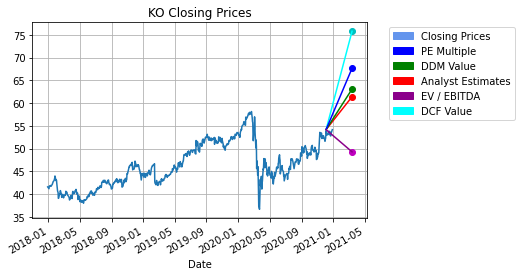

,3 Months,1 Month,Current
Buy,N/A,14.00,15.00
Overweight,N/A,2.00,2.00
Hold,N/A,5.00,5.00
Underweight,N/A,0.00,0.00
Sell,N/A,0.00,0.00
Consensus,N/A,Overweight,Overweight


In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#show price history of the stock over the last three years based on closing prices
fig, ax = plt.subplots()
hist = stock.history(period='36mo')
hist.Close.plot(title = ticker + " Closing Prices",
               grid = True)

time_for_evaluation = 18700 #where to plot the datapoints on the x-axis

#define the different points on the plot
plt.plot(time_for_evaluation, price_targets.iloc[3:4,-1][0], 'ro' ) #analyst estimates
plt.plot(time_for_evaluation, equity_value_per_share ,'co') #DCF
plt.plot(time_for_evaluation, DDM_value[0],'go') #DDM
plt.plot(time_for_evaluation, share_value_target ,'mo') #EV / EBITDA
plt.plot(time_for_evaluation, price_target ,'bo') #pe multiple
plt.legend()

#create the labels for the legend
close = mpatches.Patch(color='cornflowerblue', label='Closing Prices')
analyst = mpatches.Patch(color='red', label='Analyst Estimates')
dcf = mpatches.Patch(color='cyan', label='DCF Value')
ddm = mpatches.Patch(color='green', label='DDM Value')
evebitda = mpatches.Patch(color='darkmagenta', label='EV / EBITDA')
pe = mpatches.Patch(color='blue', label='PE Multiple')

# plot each datapoint
x = [18600, time_for_evaluation]
y_analyst = [current_price, price_targets.iloc[3:4,-1][0]]
plt.plot(x,y_analyst, 'r')

y_dcf = [current_price, equity_value_per_share]
plt.plot(x,y_dcf, 'cyan')

y_ddm = [current_price,DDM_value[0] ]
plt.plot(x,y_ddm, 'green')

y_pe = [current_price, price_target]
plt.plot(x,y_pe, 'blue')

y_evebitda = [current_price, share_value_target]
plt.plot(x,y_evebitda, 'darkmagenta')


ax.legend(handles = [close, pe, ddm, analyst, evebitda, dcf], bbox_to_anchor=(1.05, 1))
plt.show()

#also print the analyst recommendations
marketwatch

# Part 3: Sentiment Analysis

This part of the model performs a sentiment analysis on recent news articles published by reuters in regards to the target company. The model uses Vader, a lexicon based sentiment tool to compute a news article sentiment score. Since Vader is not constructed based on finance news, we update the Vader lexicon with further words from Loughran McDonald. Finally, the model shows the most extreme news articles and the overal sentiment score, which ranges from -1 (really negative) to 1 (really positive).

In [43]:
import nltk
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
#Cite: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text.
#Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\subuser\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
#Go to the firms site on Reuters.com
url_reuters = "https://www.reuters.com/companies/"+ticker
page = requests.get(url_reuters)
soup = BeautifulSoup(page.content, 'html.parser')
site = []
news = []
reuters_news = soup.find_all("body")
for string in reuters_news[0].strings:
    site.append((string))
#Find the latest news articles
latest_news = site.index("Latest News")+3
end = site.index("Quote and financial data from Refinitiv. Fund performance data provided by Lipper. All quotes delayed a minimum of 15 minutes.")
#Loop through all the news articles and safe the headline with the following text
reached_end = False
while reached_end is False:
    title = site[latest_news]
    text = site[(latest_news + 1)]
    title_text = title + ": " + text
    news.append(title_text)
    latest_news = latest_news + 2
    if latest_news >= end:
        reached_end = True
#Create a dataframe with all the news
overview_news = {"News" : news}
overview_news = pd.DataFrame(overview_news, columns = ["News"])
pd.set_option('display.max_colwidth', None)
overview_news

,News
0,"Fact check: La Coca-Cola no produce un resultado positivo en el test de COVID-19: Varios usuarios de redes sociales han estado compartiendo un contenido que muestra a Michael Schnedlitz, miembro del Consejo Nacional de Austria, aplicando un test de COVID-19 a un vaso con Coca-Cola que supuestamente arrojaría un resultado positivo. Esta afirmación es falsa..."
1,"Fact check: Coca-Cola does not cause a positive COVID-19 test : Social media users have been sharing content online showing Michael Schnedlitz, a member of the National Council of Austria, using a COVID-19 test on a glass of Coca-Cola and the results appearing to be positive. This claim is false: if done correctly, COVID-19 tests will..."
2,Uzbekistan invites bids for its stake in joint venture with Coca-Cola: The government of Uzbekistan on Friday invited potential investors to express interest in its stake in a joint venture with Coca-Cola and said Rothschild was its exclusive advisor for the planned deal.
3,"Coca-Cola to cut 2,200 jobs globally, including 1,200 in U.S.: Coca-Cola Co will cut 2,200 jobs globally, including 1,200 in the United States, it said on Thursday, as the economic fallout from the COVID-19 pandemic forces the world's largest soda maker to accelerate its business restructuring."
4,"Coca-Cola to cut 2,200 jobs- WSJ: Coca-Cola Co is cutting 2,200 jobs globally, including 1,200 in the United States, as part of its restructuring efforts, the Wall Street Journal reported on Thursday."
5,European Coke bottler to hike ad spend for returning events: Coca Cola HBC <CCH.L> said it will be raising its advertising spending in 2021 to target returning events as a rebound in demand from restaurants helped the soft drinks bottler beat third-quarter sales estimates on Wednesday.
6,"Take a stance or tiptoe away? Corporate America's battle with social activism: Earlier this year, a flood of major U.S. companies pledged to address racial inequality and promote social justice after Minneapolis police killed George Floyd, a Black man, setting off protests across the country."
7,"Coca-Cola's European partner makes $6.6 billion play for Australia bottler: Coca-Cola Co's European bottler has made a A$9.28 billion ($6.6 billion) buyout approach to Australian peer Coca-Cola Amatil Ltd, a cut-price proposal that the target firm is backing due to uncertainty sparked by the coronavirus crisis."
8,Coca-Cola emerges from lockdown blues as out-of-home demand recovers: Coca-Cola Co <KO.N> beat revenue and profit expectations on Thursday as a partial reopening of theaters and restaurants boosted demand and helped the world's largest soda maker bounce back from a shattering second quarter.
9,"Coca-Cola revenue beats expectations as consumers venture out: Coca-Cola Co beat quarterly revenue expectations on Thursday as the world's largest soda maker benefited from the partial reopening of theaters and restaurants, which have remained shut for months due to the COVID-19 pandemic."


### Cleaning the news articles

In [45]:
import string
cleaned_news = []
for news_article in overview_news["News"]:
    #Split words with space
    words = news_article.split()
    #Normalizing:
    words = [word.lower() for word in words]
    #Remove punctuations
    punctuations = string.punctuation
    #But do not remove . ! ? , > and <
    punctuations = punctuations.replace("<", "")
    punctuations = punctuations.replace(">", "")
    punctuations = punctuations.replace(".", "")
    punctuations = punctuations.replace("!", "")
    punctuations = punctuations.replace("?", "")
    punctuations = punctuations.replace(",", "")
    table = str.maketrans('', '', punctuations)
    words = [w.translate(table) for w in words]    
    #remove ticker & stop words with the nltk library
    #https://www.nltk.org/nltk_data/
    #Import english stop words from  nltk
    stop_words_list = set(stopwords.words('english'))
    for word in words:
        if word[:1] == "<" and word[-1:] == ">":
            words.pop(words.index(word))
        if word in stop_words_list:
            words.pop(words.index(word))
    cleaned_news.append(words)

In [46]:
#Combine the cleaned words into sentences
cleaned_news_combined = []
for news_article in cleaned_news:
    text = ""
    for word in news_article:
        text = text +" " + word
    cleaned_news_combined.append(text)
cleaned_news_combined = pd.DataFrame(cleaned_news_combined, columns = ["News"])
cleaned_news_combined

,News
0,"fact check la cocacola produce un resultado positivo en el test de covid19 varios usuarios de redes sociales han estado compartiendo un contenido que muestra michael schnedlitz, miembro del consejo nacional de austria, aplicando un test de covid19 un vaso con cocacola que supuestamente arrojaría un resultado positivo. esta afirmación es falsa..."
1,"fact check cocacola not cause positive covid19 test social media users been sharing content online showing michael schnedlitz, member the national council austria, using covid19 test a glass cocacola the results appearing be positive. claim false done correctly, covid19 tests will..."
2,uzbekistan invites bids its stake joint venture cocacola government uzbekistan friday invited potential investors express interest its stake a joint venture cocacola said rothschild its exclusive advisor the planned deal.
3,"cocacola cut 2,200 jobs globally, including 1,200 u.s. cocacola co cut 2,200 jobs globally, including 1,200 united states, said thursday, the economic fallout the covid19 pandemic forces the worlds largest soda maker accelerate business restructuring."
4,"cocacola cut 2,200 jobs wsj cocacola co cutting 2,200 jobs globally, including 1,200 united states, part its restructuring efforts, the wall street journal reported thursday."
5,european coke bottler hike ad spend returning events coca cola hbc said will raising advertising spending 2021 target returning events a rebound demand restaurants helped soft drinks bottler beat thirdquarter sales estimates wednesday.
6,"take stance tiptoe away? corporate americas battle social activism earlier year, flood major u.s. companies pledged address racial inequality promote social justice minneapolis police killed george floyd, black man, setting protests across country."
7,"cocacolas european partner makes 6.6 billion play australia bottler cocacola cos european bottler made a9.28 billion 6.6 billion buyout approach australian peer cocacola amatil ltd, cutprice proposal the target firm backing due uncertainty sparked the coronavirus crisis."
8,cocacola emerges lockdown blues outofhome demand recovers cocacola co beat revenue profit expectations thursday a partial reopening theaters restaurants boosted demand helped worlds largest soda maker bounce back a shattering second quarter.
9,"cocacola revenue beats expectations consumers venture cocacola co beat quarterly revenue expectations thursday the worlds largest soda maker benefited the partial reopening theaters restaurants, have remained shut months due the covid19 pandemic."


### Training the model

In [47]:
#https://towardsdatascience.com/stock-news-sentiment-analysis-with-python-193d4b4378d4
vader = SentimentIntensityAnalyzer()

In [48]:
scores = cleaned_news_combined["News"].apply(vader.polarity_scores).tolist()
df_scores = pd.DataFrame(scores)
cleaned_news_combined_vader = cleaned_news_combined.join(df_scores, rsuffix='_right')

In [49]:
#Calculate the average intensity for positive & negative in the Vader lexicon
sum_pos = 0
sum_neg = 0
number_pos = 0
number_neg = 0
for i in vader.lexicon:
    if vader.lexicon[i] > 0:
        sum_pos = sum_pos + float(vader.lexicon[i])
        number_pos = number_pos + 1
    if vader.lexicon[i] < 0:
        sum_neg = sum_neg + float(vader.lexicon[i])
        number_neg = number_neg + 1    
print("Average positive intensity: ", sum_pos / number_pos)
avg_pos_int = sum_pos / number_pos
print("Average negative intensity: ", sum_neg / number_neg)
avg_neg_int = sum_neg / number_neg

Average positive intensity:  1.5313531353135323
Average negative intensity:  -1.5516670664427912


In [50]:
#Use the word list from Loughran McDonald/
#File safed in folder
external_word_list = pd.read_csv("word_list.csv", sep = ";")
external_word_list
#Drop columns we do not need
word_list = external_word_list.drop(columns = ["Word Proportion", "Average Proportion", "Std Dev", "Litigious", "Constraining", "Superfluous", "Interesting", "Modal", "Irr_Verb", "Harvard_IV", "Syllables", "Source", "Uncertainty"])
#replace year with the average of the Vader lexicon. -1.55 for negative and 1.53 for the positive words
word_list = word_list.drop(word_list[(word_list["Negative"]<1) & (word_list["Positive"]<1)].index)
for i in range(0, len(word_list["Negative"])):
    if word_list["Negative"][i] > 1:
        word_list.loc[i, "Negative"] = avg_neg_int
    if word_list["Positive"][i] > 1:
        word_list.loc[i, "Positive"] = avg_pos_int
    word_list.loc[i, "Word"] = word_list.loc[i, "Word"].lower()
word_list["Neg & Pos"] = word_list["Negative"] + word_list["Positive"]
word_list

,Word,Sequence Number,Word Count,Doc Count,Negative,Positive,Neg & Pos
0,cyberattack,17897,1051,708,-1.55,0.00,-1.55
1,cyberattacks,17898,3404,1984,-1.55,0.00,-1.55
2,cyberbullying,17899,49,25,-1.55,0.00,-1.55
3,cybercrime,17900,368,317,-1.55,0.00,-1.55
4,cybercrimes,17901,23,19,-1.55,0.00,-1.55
...,...,...,...,...,...,...,...
2704,win,85239,89209,32229,0.00,1.53,1.53
2705,winner,85361,11358,4813,0.00,1.53,1.53
2706,winners,85362,7931,3529,0.00,1.53,1.53
2707,winning,85363,49950,25960,0.00,1.53,1.53


In [51]:
#Create Dictionary
words_for_model = {}
for number in range(0, len(word_list["Word"])):
    #If word already in vader skip the word (there are around 200 doubles)
    if word_list.loc[number, "Word"] not in vader.lexicon:
        value = word_list.loc[number, "Neg & Pos"]
        key = word_list.loc[number, "Word"]   
        words_for_model[key] = value
#the combined lexicon used to compute the sentiment score on the news articles
words_for_model

{'cyberattack': -1.5516670664427912,
 'cyberattacks': -1.5516670664427912,
 'cyberbullying': -1.5516670664427912,
 'cybercrime': -1.5516670664427912,
 'cybercrimes': -1.5516670664427912,
 'cybercriminal': -1.5516670664427912,
 'cybercriminals': -1.5516670664427912,
 'mischaracterization': -1.5516670664427912,
 'misclassifications': -1.5516670664427912,
 'misclassify': -1.5516670664427912,
 'miscommunication': -1.5516670664427912,
 'misprice': -1.5516670664427912,
 'mispricing': -1.5516670664427912,
 'mispricings': -1.5516670664427912,
 'redefault': -1.5516670664427912,
 'redefaults': -1.5516670664427912,
 'underperforms': -1.5516670664427912,
 'unfavorability': -1.5516670664427912,
 'unmeritorious': -1.5516670664427912,
 'unreceptive': -1.5516670664427912,
 'unsellable': -1.5516670664427912,
 'unstabilized': -1.5516670664427912,
 'untrusted': -1.5516670664427912,
 'redefaulted': -1.5516670664427912,
 'unforseen': -1.5516670664427912,
 'unpredicted': -1.5516670664427912,
 'aversely': -1

In [52]:
#Update the word list
vader.lexicon.update(words_for_model)

In [53]:
scores = cleaned_news_combined["News"].apply(vader.polarity_scores).tolist()
df_scores = pd.DataFrame(scores)
cleaned_news_combined = cleaned_news_combined.join(df_scores, rsuffix='_right')

### Results

In [54]:
#Shows the result with the adapted Vader model
pd.set_option('display.max_colwidth', None)
cleaned_news_combined

,News,neg,neu,pos,compound
0,"fact check la cocacola produce un resultado positivo en el test de covid19 varios usuarios de redes sociales han estado compartiendo un contenido que muestra michael schnedlitz, miembro del consejo nacional de austria, aplicando un test de covid19 un vaso con cocacola que supuestamente arrojaría un resultado positivo. esta afirmación es falsa...",0.00,1.00,0.00,0.00
1,"fact check cocacola not cause positive covid19 test social media users been sharing content online showing michael schnedlitz, member the national council austria, using covid19 test a glass cocacola the results appearing be positive. claim false done correctly, covid19 tests will...",0.18,0.76,0.06,-0.68
2,uzbekistan invites bids its stake joint venture cocacola government uzbekistan friday invited potential investors express interest its stake a joint venture cocacola said rothschild its exclusive advisor the planned deal.,0.00,0.86,0.14,0.54
3,"cocacola cut 2,200 jobs globally, including 1,200 u.s. cocacola co cut 2,200 jobs globally, including 1,200 united states, said thursday, the economic fallout the covid19 pandemic forces the worlds largest soda maker accelerate business restructuring.",0.22,0.71,0.07,-0.67
4,"cocacola cut 2,200 jobs wsj cocacola co cutting 2,200 jobs globally, including 1,200 united states, part its restructuring efforts, the wall street journal reported thursday.",0.20,0.70,0.09,-0.33
5,european coke bottler hike ad spend returning events coca cola hbc said will raising advertising spending 2021 target returning events a rebound demand restaurants helped soft drinks bottler beat thirdquarter sales estimates wednesday.,0.04,0.88,0.07,0.26
6,"take stance tiptoe away? corporate americas battle social activism earlier year, flood major u.s. companies pledged address racial inequality promote social justice minneapolis police killed george floyd, black man, setting protests across country.",0.21,0.65,0.14,-0.46
7,"cocacolas european partner makes 6.6 billion play australia bottler cocacola cos european bottler made a9.28 billion 6.6 billion buyout approach australian peer cocacola amatil ltd, cutprice proposal the target firm backing due uncertainty sparked the coronavirus crisis.",0.15,0.77,0.08,-0.61
8,cocacola emerges lockdown blues outofhome demand recovers cocacola co beat revenue profit expectations thursday a partial reopening theaters restaurants boosted demand helped worlds largest soda maker bounce back a shattering second quarter.,0.09,0.76,0.16,0.53
9,"cocacola revenue beats expectations consumers venture cocacola co beat quarterly revenue expectations thursday the worlds largest soda maker benefited the partial reopening theaters restaurants, have remained shut months due the covid19 pandemic.",0.07,0.85,0.07,-0.01


In [55]:
#Put the average sentiment score into classes, to provide the user with a fast overview.
average = round(cleaned_news_combined["compound"].mean(), 3)
if average > 0.75:
    news_score = "really positive"
elif average > 0.25:
    news_score = "positive"
elif average > 0:
    news_score = "neutral to positive"
elif average > -0.25:
    news_score = "negative to neutral"
elif average > -0.75:
    news_score = "negative"
elif average > -1:
    news_score = "really negative"
print("The last 20 published news article on Reuters were on average", news_score,". With an average valance score of ", average)
print("These articels are the most extreme ones:")
news_final = pd.DataFrame(cleaned_news_combined, columns = ["News"])
news_final["Score"] = cleaned_news_combined["compound"]
news_final["intensity"] = cleaned_news_combined["compound"].abs()
news_final.nlargest(3, "intensity")

The last 20 published news article on Reuters were on average neutral to positive . With an average valance score of  0.015
These articels are the most extreme ones:


,News,Score,intensity
18,cocacola cut jobs restructuring cocacola co said friday would reduce global workforce part a companywide restructuring.,-0.74,0.74
15,"cocacola bottlers feeling flat, even u.s. grocery sales sparkle martin williams greatgrandfather founded cocacola distribution business corinth, mississippi, 1907, a handful years coke first sold bottles across united states.",0.73,0.73
1,"fact check cocacola not cause positive covid19 test social media users been sharing content online showing michael schnedlitz, member the national council austria, using covid19 test a glass cocacola the results appearing be positive. claim false done correctly, covid19 tests will...",-0.68,0.68


### Comparison Vader original with the adapted Vader version using the ticker Coca Cola

Sentiment analysis can be used in many situations, however, there is no free model especially for financial news. Since Vader was created for social media related text, we adapted the model with additional features. This part will analyse the results for both, the original and adapted model. In order to do so we use pre scraped and pre classified news articles for Coca Cola. The interpreted results and further recommendations for improvements are presented in the research paper. As the testing of model accuracy requires human input, it cannot be done for every single company. Therefore this was created as a one time test with Coca Cola.

In [ ]:
#import data#
#Get the pre scraped coca cola news articles
sentiment_theory = pd.read_excel("ko_sentiment.xlsx", sheet_name = "cleaned_news_combined")

In [ ]:
#In order to analyse the two models, we classified the news articles into positive, neutral and negative
opinion = [1, 0, 1, 1, 1, -1, -1, 1, 1, 0, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1]

In [ ]:
#Compares the result between the adapted vader, original vader model and human opinion
sentiment_theory["Human Opinion"] = opinion
sentiment_theory = sentiment_theory.drop(["neg", "pos", "neu"], axis = 1)
sentiment_theory[(sentiment_theory["Dif"]!=0)]                  

In [ ]:
#Adapted Vader Model
sum_corr_pos = len(sentiment_theory[(sentiment_theory["compound"] >0) & (sentiment_theory["Human Opinion"]>0)])
sum_corr_neg = len(sentiment_theory[(sentiment_theory["compound"] <0) & (sentiment_theory["Human Opinion"]<0)])
num_pos = len(sentiment_theory[(sentiment_theory["Human Opinion"] >0)])
num_neg = len(sentiment_theory[(sentiment_theory["Human Opinion"] <0)])
print("Adapted Vader Model")
print("correct classified positive: ", sum_corr_pos / num_pos)
print("correct classified negative: ", sum_corr_neg / num_neg)

In [ ]:
#Original Vader Model
sum_corr_pos = len(sentiment_theory[(sentiment_theory["Vader with no changes"] >0) & (sentiment_theory["Human Opinion"]>0)])
sum_corr_neg = len(sentiment_theory[(sentiment_theory["Vader with no changes"] <0) & (sentiment_theory["Human Opinion"]<0)])
num_pos = len(sentiment_theory[(sentiment_theory["Human Opinion"] >0)])
num_neg = len(sentiment_theory[(sentiment_theory["Human Opinion"] <0)])
print("Original Vader Model")
print("correct classified positive: ", sum_corr_pos / num_pos)
print("correct classified negative: ", sum_corr_neg / num_neg)

End of the notebook